# Mapping cancer cells onto a healthy reference using Symphony
June 11, 2021

In this notebook, we will map a renal cell carcinoma (RCC) dataset (Bi et al., Cancer Cell, 2021) onto a reference of healthy fetal human kidney cells (Stewart et al., Science, 2019). 

* Reference dataset: https://www.kidneycellatlas.org/ (Fetal full)
* Query dataset: https://singlecell.broadinstitute.org/single_cell/study/SCP1288/tumor-and-immune-reprogramming-during-immunotherapy-in-advanced-renal-cell-carcinoma#study-summary

Note: We found that the reference dataset gene names were assigned using Gencode v24, whereas the query dataset gene names were assigned using Gencode v30 liftover37 (gtf file provided by Kevin Bi). Therefore, to sync the two datasets, we used the Ensembl IDs of the reference genes to "convert" them to Gencode v30 gene names.

In [1]:
suppressPackageStartupMessages({
    library(purrr)
    library(data.table)
    library(furrr)
    library(glue)
    library(future)
    library(rtracklayer)})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

## Determine Gencode version used for gene expression matrix construction
Gencode code from Ilya Korsunsky (May 2021)

First, let's download all the GTF files to examine. The URLs have mostly the 
same format: 

In [2]:
urls <- c(
  ## GRCh38
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{22:38}/gencode.v{22:38}.primary_assembly.annotation.gtf.gz'),
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{20:21}/gencode.v{20:21}.chr_patch_hapl_scaff.annotation.gtf.gz'),
  ## GRCh37
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{16:19}/gencode.v{16:19}.chr_patch_hapl_scaff.annotation.gtf.gz'),
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{4}/gencode_v{4}.annotation.GRCh37.gtf.gz'),
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{5:15}/gencode.v{5:15}.annotation.gtf.gz'),
  'http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_3d/gencode.v3d.gtf.gz'
)

Because we will write these into the raw data directory with restricted write 
access, we'll need to wget with sudo, so execute these commands in the terminal:

In [4]:
cmds <- as.character(glue('wget -P ../data/GENCODE {urls}'))
map(cmds, system)

Next, let's read in the gtfs and extract gene names. 

In [5]:
datadir <- '../data/GENCODE/'
fnames <- list.files(datadir, pattern='gencode.v\\d+.*gtf.gz')
## This step takes a while! Loads ~15GB of data 
plan(multicore)
gtfs <- file.path(datadir, fnames) %>% future_map(rtracklayer::import)
names(gtfs) <- gsub('(gencode.v\\d+).*', '\\1', fnames)

## gene symbols
gtf_genes <- gtfs %>% map(data.frame) %>% map('gene_name') %>% map(unique)

## ensembl IDs
gtf_ids <- gtfs %>% map(data.frame) %>% map('gene_id') %>% map(unique)

### Which gencode version was used for the reference dataset?

Now that we know which genes are accounted for in each GENCODE version, let's 
compare our gene names. In this example, gencode v24 has the only GTF that 
contains almost all the genes from our matrix, so it is clearly our winner. 

In [102]:
genes_reference = read.csv('/data/srlab2/jkang/datasets/stewart_kidney_science_2019/Mature_Full_v3_genes.csv', header = T)
genes_reference %>% head(3)
nrow(genes_reference)

X            ID              Symbol      
1 RP11-34P13.3 ENSG00000243485 RP11-34P13.3
2 FAM138A      ENSG00000237613 FAM138A     
3 OR4F5        ENSG00000186092 OR4F5

[1] 33694

In [16]:
message('Number of genes not covered by the GTF:')
map_dbl(gtf_genes, function(g) length(setdiff(genes_reference$Symbol, g))) %>% sort() %>% head()

Number of genes not covered by the GTF:



gencode.v24 gencode.v25 gencode.v23 gencode.v22 gencode.v21 gencode.v26 
         36         277         306         548        1023        1192

Seems like gencode v24 is the best matching GTF.

### Which gencode version was used for the query dataset?

In [17]:
query_exp = fread('/data/srlab2/jkang/datasets/bi_rcc_cancer_cell_2021/ccRCC_scRNASeq_NormalizedCounts.txt', 
                       sep = '\t', header = TRUE)
rownames = query_exp$GENE
query_exp = as.matrix(query_exp[, -1])
rownames(query_exp) = rownames
dim(query_exp)
query_exp[1:5, 1:5]

[1] 32718 34326

AAACCTGAGAATAGGG.p55 AAACCTGAGGCTAGGT.p55 AAACCTGCACTGTGTA.p55
WASH7P       0                    0                    0                   
AL627309.1   0                    0                    0                   
AL627309.3   0                    0                    0                   
CICP27       0                    0                    0                   
AL627309.1.1 0                    0                    0                   
             AAACCTGCAGTCCTTC.p55 AAACCTGGTAAATGTG.p55
WASH7P       0                    0                   
AL627309.1   0                    0                   
AL627309.3   0                    0                   
CICP27       0                    0                   
AL627309.1.1 0                    0

In [18]:
message('Number of genes not covered by the GTF:')
map_dbl(gtf_genes, function(g) length(setdiff(rownames, g))) %>% sort() %>% head()

Number of genes not covered by the GTF:



gencode.v30 gencode.v31 gencode.v32 gencode.v29 gencode.v33 gencode.v34 
        667         832         986        1071        1218        1338

Looks like the query RCC dataset used gencode v30.

In [20]:
## List of genes with different names
length(setdiff(rownames, genes_reference$Symbol))
length(intersect(rownames, genes_reference$Symbol))
setdiff(rownames, genes_reference$Symbol) %>% head(3) # gene names present in query but missing in ref

[1] 14092

[1] 18626

[1] "WASH7P"     "AL627309.1" "AL627309.3"

In [100]:
# Get mapping from Ensembl IDs to query gene names (v30)
gtf <- rtracklayer::import('gencode.v30lift37.annotation.gtf') # gtf file obtained from Kevin Bi on 6/1/2021
gtf_df = as.data.frame(gtf)[, c('gene_id', 'gene_name')]
gtf_df$gene_id_short = gsub("\\..*","",gtf_df$gene_id) # remove everything after '.'
gtf_mapping = unique(gtf_df) # remove duplicate columns
gtf_mapping %>% head(3)

gene_id             gene_name   gene_id_short  
1  ENSG00000223972.5_2 DDX11L1     ENSG00000223972
13 ENSG00000227232.5_2 WASH7P      ENSG00000227232
26 ENSG00000243485.5_5 MIR1302-2HG ENSG00000243485

In [103]:
# How many reference Ensembl IDs are not present in the v30 mapping?
length(setdiff(genes_reference$ID, gtf_mapping$gene_id_short))

[1] 786

Let's lift the reference (v24) gene names over to v30 using the same GTF file as the query!

In [104]:
reference_v30_Symbols = gtf_mapping[match(genes_reference$ID, gtf_mapping$gene_id_short), 'gene_name']
length(reference_v30_Symbols)
head(genes_reference$Symbol) # old
head(genes_reference$ID) # id
head(reference_v30_Symbols) # new

[1] 33694

[1] "RP11-34P13.3"  "FAM138A"       "OR4F5"         "RP11-34P13.7" 
[5] "RP11-34P13.8"  "RP11-34P13.14"

[1] "ENSG00000243485" "ENSG00000237613" "ENSG00000186092" "ENSG00000238009"
[5] "ENSG00000239945" "ENSG00000239906"

[1] "MIR1302-2HG" "FAM138A"     "OR4F5"       "AL627309.1"  "AL627309.3" 
[6] "AL627309.2"

In [105]:
sum(is.na(reference_v30_Symbols)) # only 786 genes did not carry over

[1] 786

In [106]:
saveRDS(reference_v30_Symbols, 'reference_v30_Symbols.rds')

## Run Symphony experiment with fetal healthy kidney
Both datasets with Gencode v30 (synced gene names)

In [2]:
suppressPackageStartupMessages({
    library(symphony)
    library(irlba)
    library(tidyverse)
    library(RColorBrewer)
    library(pheatmap)
    library(ggrastr)
})

mycolors = c(brewer.pal(name="Set1", n = 8), brewer.pal(name="Set2", n = 8),
             brewer.pal(name='Set3', n = 12),
             brewer.pal(name="Dark2", n = 8),
             brewer.pal(name='Accent', n = 7), 
             brewer.pal(name="Paired", n = 12),
             brewer.pal(name='Greens', n=4))

In [3]:
# Read in reference expression matrix and metadata
reference_v30_Symbols = readRDS('reference_v30_Symbols.rds')
ref_exp = readRDS('../data/cancer/Fetal_Full_v3_corrected_counts.rds')
metadata = read.csv('../data/cancer/Fetal_Full_v3_metadata.csv')
metadata %>% head(3)
dim(metadata)

X                                             Barcode           
1 4834STDY7002875_F16_KI_45P_AAAGCAATCCATGAGT-1 AAAGCAATCCATGAGT-1
2 4834STDY7002875_F16_KI_45P_AACGTTGGTAGCTTGT-1 AACGTTGGTAGCTTGT-1
3 4834STDY7002875_F16_KI_45P_AACTCCCTCTTAGCCC-1 AACTCCCTCTTAGCCC-1
  Short_Sample               Experiment Gender Age Stage Selection
1 4834STDY7002875_F16_KI_45P F16        M      8+1 1     CD45+    
2 4834STDY7002875_F16_KI_45P F16        M      8+1 1     CD45+    
3 4834STDY7002875_F16_KI_45P F16        M      8+1 1     CD45+    
  celltype          compartment
1 Fibroblast 1      stroma     
2 Stroma progenitor stroma     
3 Stroma progenitor stroma

[1] 27203    10

In [4]:
metadata$celltype %>% unique() %>% sort()

[1] "B cell"                             "Cap mesenchyme"                    
 [3] "CD4 T cell"                         "CD8 T cell"                        
 [5] "cDC1"                               "cDC2"                              
 [7] "CNT/PC - proximal UB"               "Distal renal vesicle"              
 [9] "Distal S shaped body"               "Endothelium"                       
[11] "Erythroid"                          "Fibroblast 1"                      
[13] "Fibroblast 2"                       "Innate like lymphocyte"            
[15] "Loop of Henle"                      "Macrophage 1"                      
[17] "Macrophage 2"                       "Mast cells"                        
[19] "Medial S shaped body"               "Megakaryocyte"                     
[21] "Monocyte"                           "Myofibroblast 1"                   
[23] "Myofibroblast 2"                    "Neuron"                            
[25] "Neutrophil"                         "NK cell"                           
[27] "pDC"                                "Pelvic epithelium - distal UB"     
[29] "Podocyte"                           "Proliferating B cell"              
[31] "Proliferating cap mesenchyme"       "Proliferating cDC2"                
[33] "Proliferating distal renal vesicle" "Proliferating fibroblast"          
[35] "Proliferating macrophage"           "Proliferating monocyte"            
[37] "Proliferating myofibroblast"        "Proliferating NK cell"             
[39] "Proliferating stroma progenitor"    "Proximal renal vesicle"            
[41] "Proximal S shaped body"             "Proximal tubule"                   
[43] "Proximal UB"                        "Stroma progenitor"

In [5]:
# Collapse proliferating immune cell labels for improved readability
metadata$cell_type <- fct_collapse(metadata$celltype,
  'B cell' = c('B cell', 'Proliferating B cell'),
  'Monocyte' = c('Proliferating monocyte', 'Monocyte'),
  'Fibroblast' = c('Fibroblast 1', 'Fibroblast 2', 'Proliferating fibroblast'),
  'cDC' = c('cDC1', 'cDC2', 'Proliferating cDC2'),
  'Macrophage' = c('Macrophage 1', 'Macrophage 2', 'Proliferating macrophage'),
  'Myofibroblast' = c('Myofibroblast 1', 'Myofibroblast 2', 'Proliferating myofibroblast'),
  'NK cell' = c('NK cell', 'Proliferating NK cell'),
  'Stroma progenitor' = c('Proliferating stroma progenitor', 'Stroma progenitor')                                
)

### Build reference

Normalize data (log CP10k)

In [6]:
exp_norm = singlecellmethods::normalizeData(ref_exp, 1e4, 'log')
max(exp_norm) # matches .h5ad file

[1] 8.569447

Subset by variable genes

In [7]:
## Rename gene names from Gencode v24 to Gencode v30
dim(ref_exp)
rownames(exp_norm) = reference_v30_Symbols
exp_norm = exp_norm [- which(is.na(rownames(exp_norm))), ] # remove NA rows that did not transfer over to v30
dim(exp_norm)

[1] 33694 27203

[1] 32908 27203

In [8]:
## Note: variable gene selection procedure potentially different from original study - 
## original paper was not clear in the Methods
vargenes = singlecellmethods::vargenes_vst(object = exp_norm, topn = 2000)
length(vargenes)

[1] 2000

Scale genes

In [9]:
exp_vargenes = exp_norm[vargenes, ]
vargenes_means_sds = tibble(symbol = vargenes, mean = Matrix::rowMeans(exp_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(exp_vargenes, vargenes_means_sds$mean)
exp_scaled = singlecellmethods::scaleDataWithStats(exp_vargenes, 
                                vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)

PCA embedding

In [10]:
set.seed(1)
# Run SVD, save gene loadings
s = irlba(exp_scaled, nv = 15)
Z_pca = diag(s$d) %*% t(s$v) # [pcs x cells]
loadings = s$u

Harmony/Symphony compression

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony converged after 5 iterations



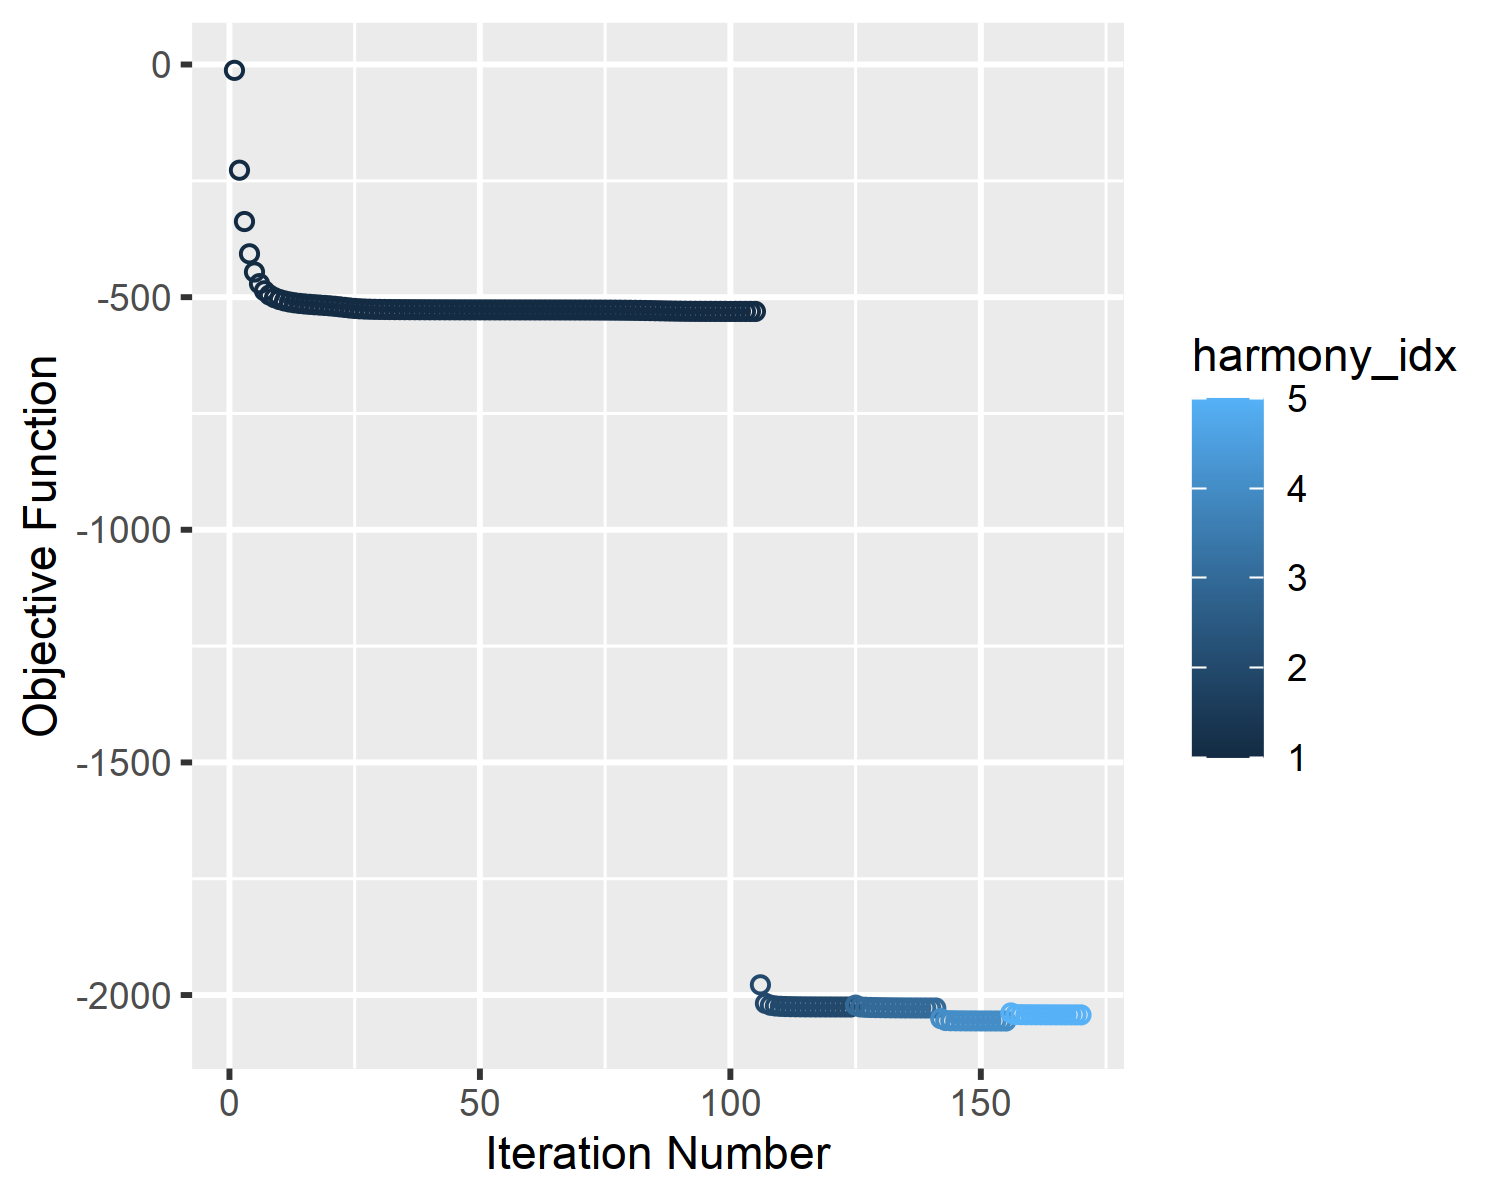

In [11]:
fig.size(4, 5)
set.seed(1)
# Harmonize the reference

harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca),       ## PCA embedding matrix of cells
        meta_data = metadata,      ## dataframe with cell labels
        theta = c(0.5),            ## diversity penalty
        vars_use = c('Experiment'),## variable to integrate out
        nclust = 100,               ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,      ## return the full Harmony model object
        do_pca = FALSE,            ## do not recompute PCs
        plot_convergence = TRUE
)

In [12]:
# Compress Harmony obj into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
            harmObj,                # output object from HarmonyMatrix()
            metadata,
            vargenes_means_sds,     # gene names, means, and std devs for scaling
            loadings,               # genes x PCs
            verbose = TRUE, 
            do_umap = TRUE,
            save_uwot_path = '/data/srlab2/jkang/symphony_reproducibility/pre-built_references/kidney_healthy_fetal_uwot_model',
            umap_min_dist = 0.3)

saveRDS(reference, '/data/srlab2/jkang/symphony_reproducibility/pre-built_references/kidney_healthy_fetal_reference.rds')

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model

Finished nicely.



Plot reference

png 
  2

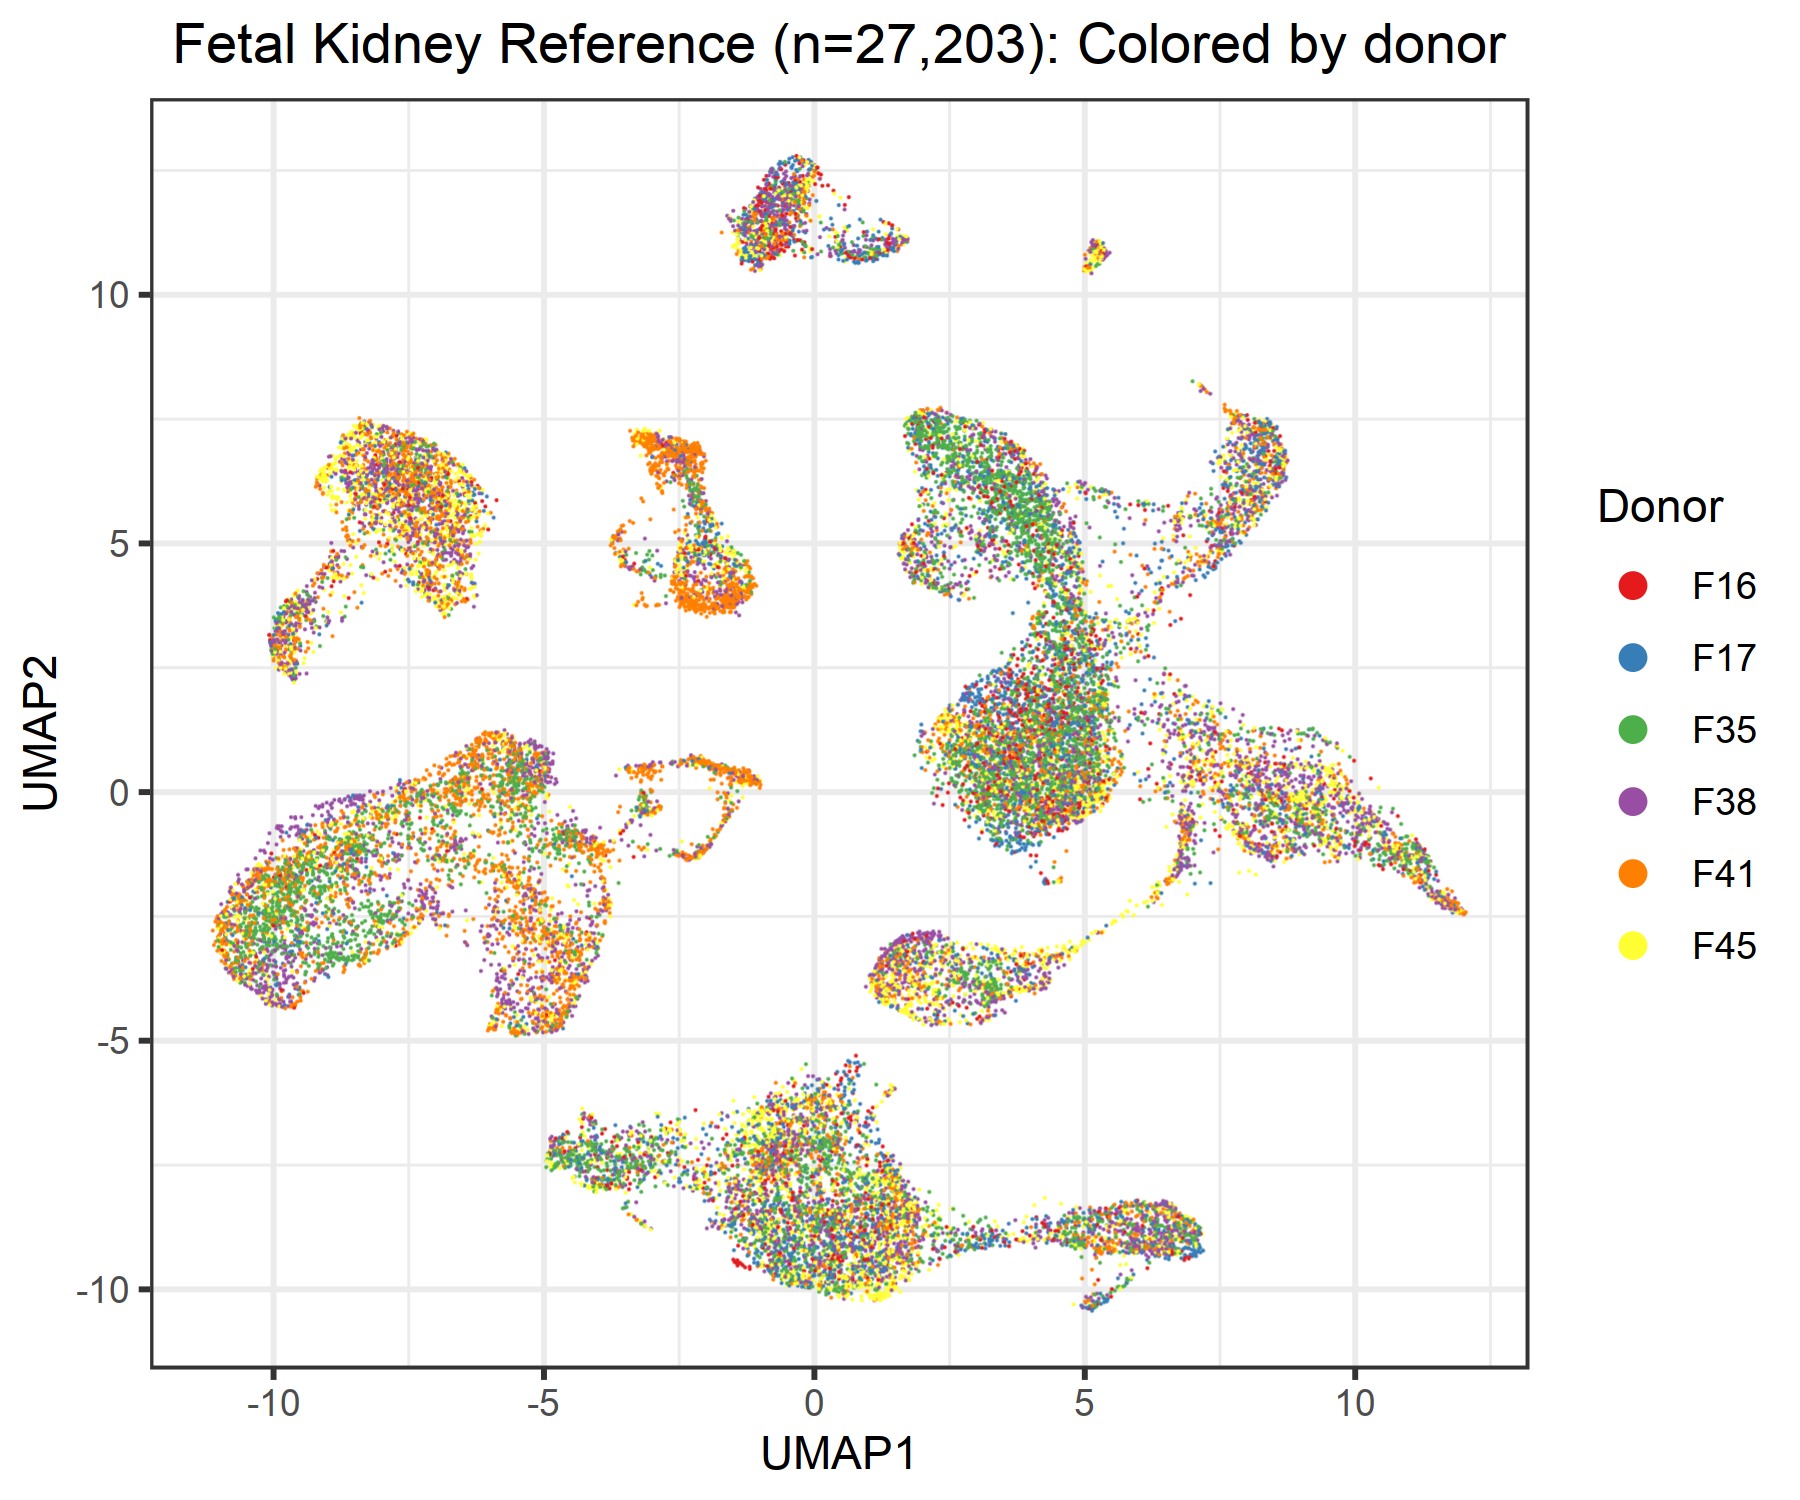

In [13]:
# Plot UMAP visualization
pdf('figures/reference_fetal_kidney_colorby_donor.pdf', height = 5, width = 6, useDingbats = FALSE)
fig.size(5, 6)

umap_labels = cbind(reference$meta_data, reference$umap$embedding)
p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = Experiment)) +
    geom_point_rast(size = 0.2, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Fetal Kidney Reference (n=27,203): Colored by donor', color = 'Donor') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size = 9)) + 
    scale_colour_brewer(palette = 'Set1') +
    guides(colour = guide_legend(override.aes = list(size = 3)))
print(p)
dev.off()
p

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


png 
  2

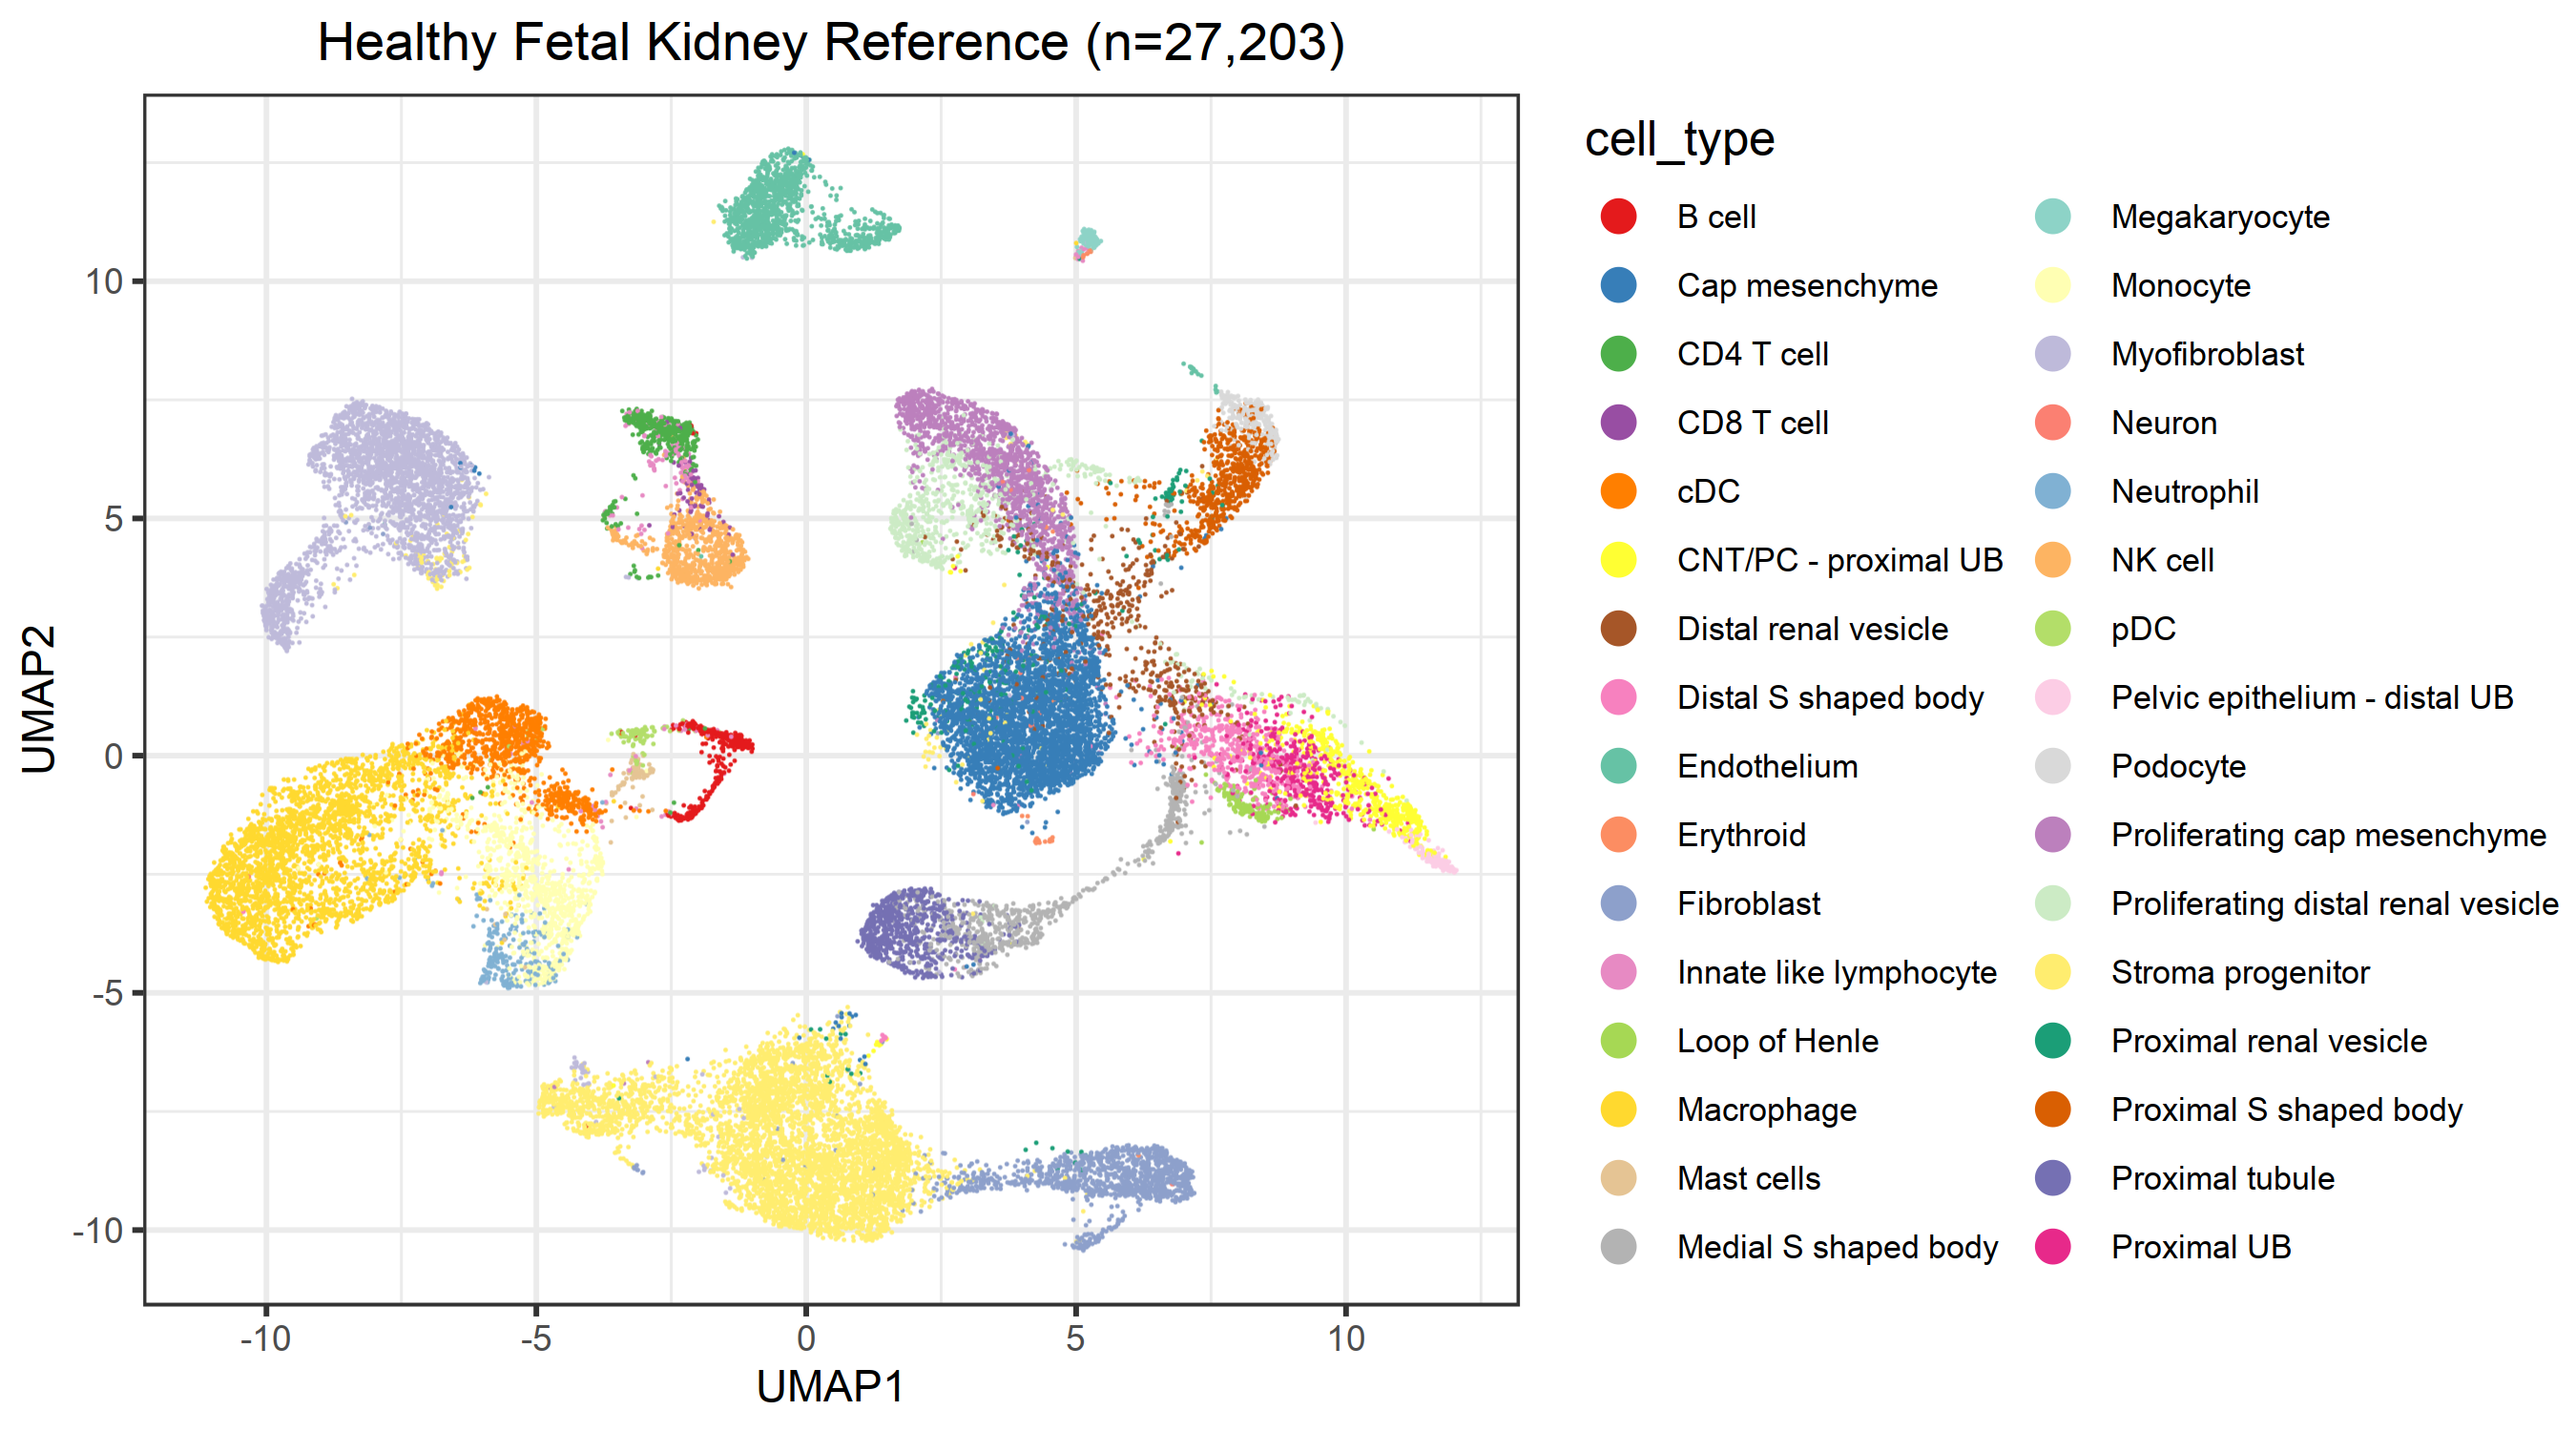

In [14]:
pdf('figures/reference_fetal_kidney_colorby_celltype.pdf', height = 5, width = 9, useDingbats = FALSE)
fig.size(5, 9)

p = symphony::plotReference(reference, color.by = 'cell_type', show.labels = FALSE, 
                    title = 'Healthy Fetal Kidney Reference (n=27,203)', 
                    as.density = FALSE, show.centroids = FALSE, celltype.colors = mycolors) + 
                    theme(legend.position = 'right')
print(p)
dev.off()
p

Adding missing grouping variables: `cell_type`



png 
  2

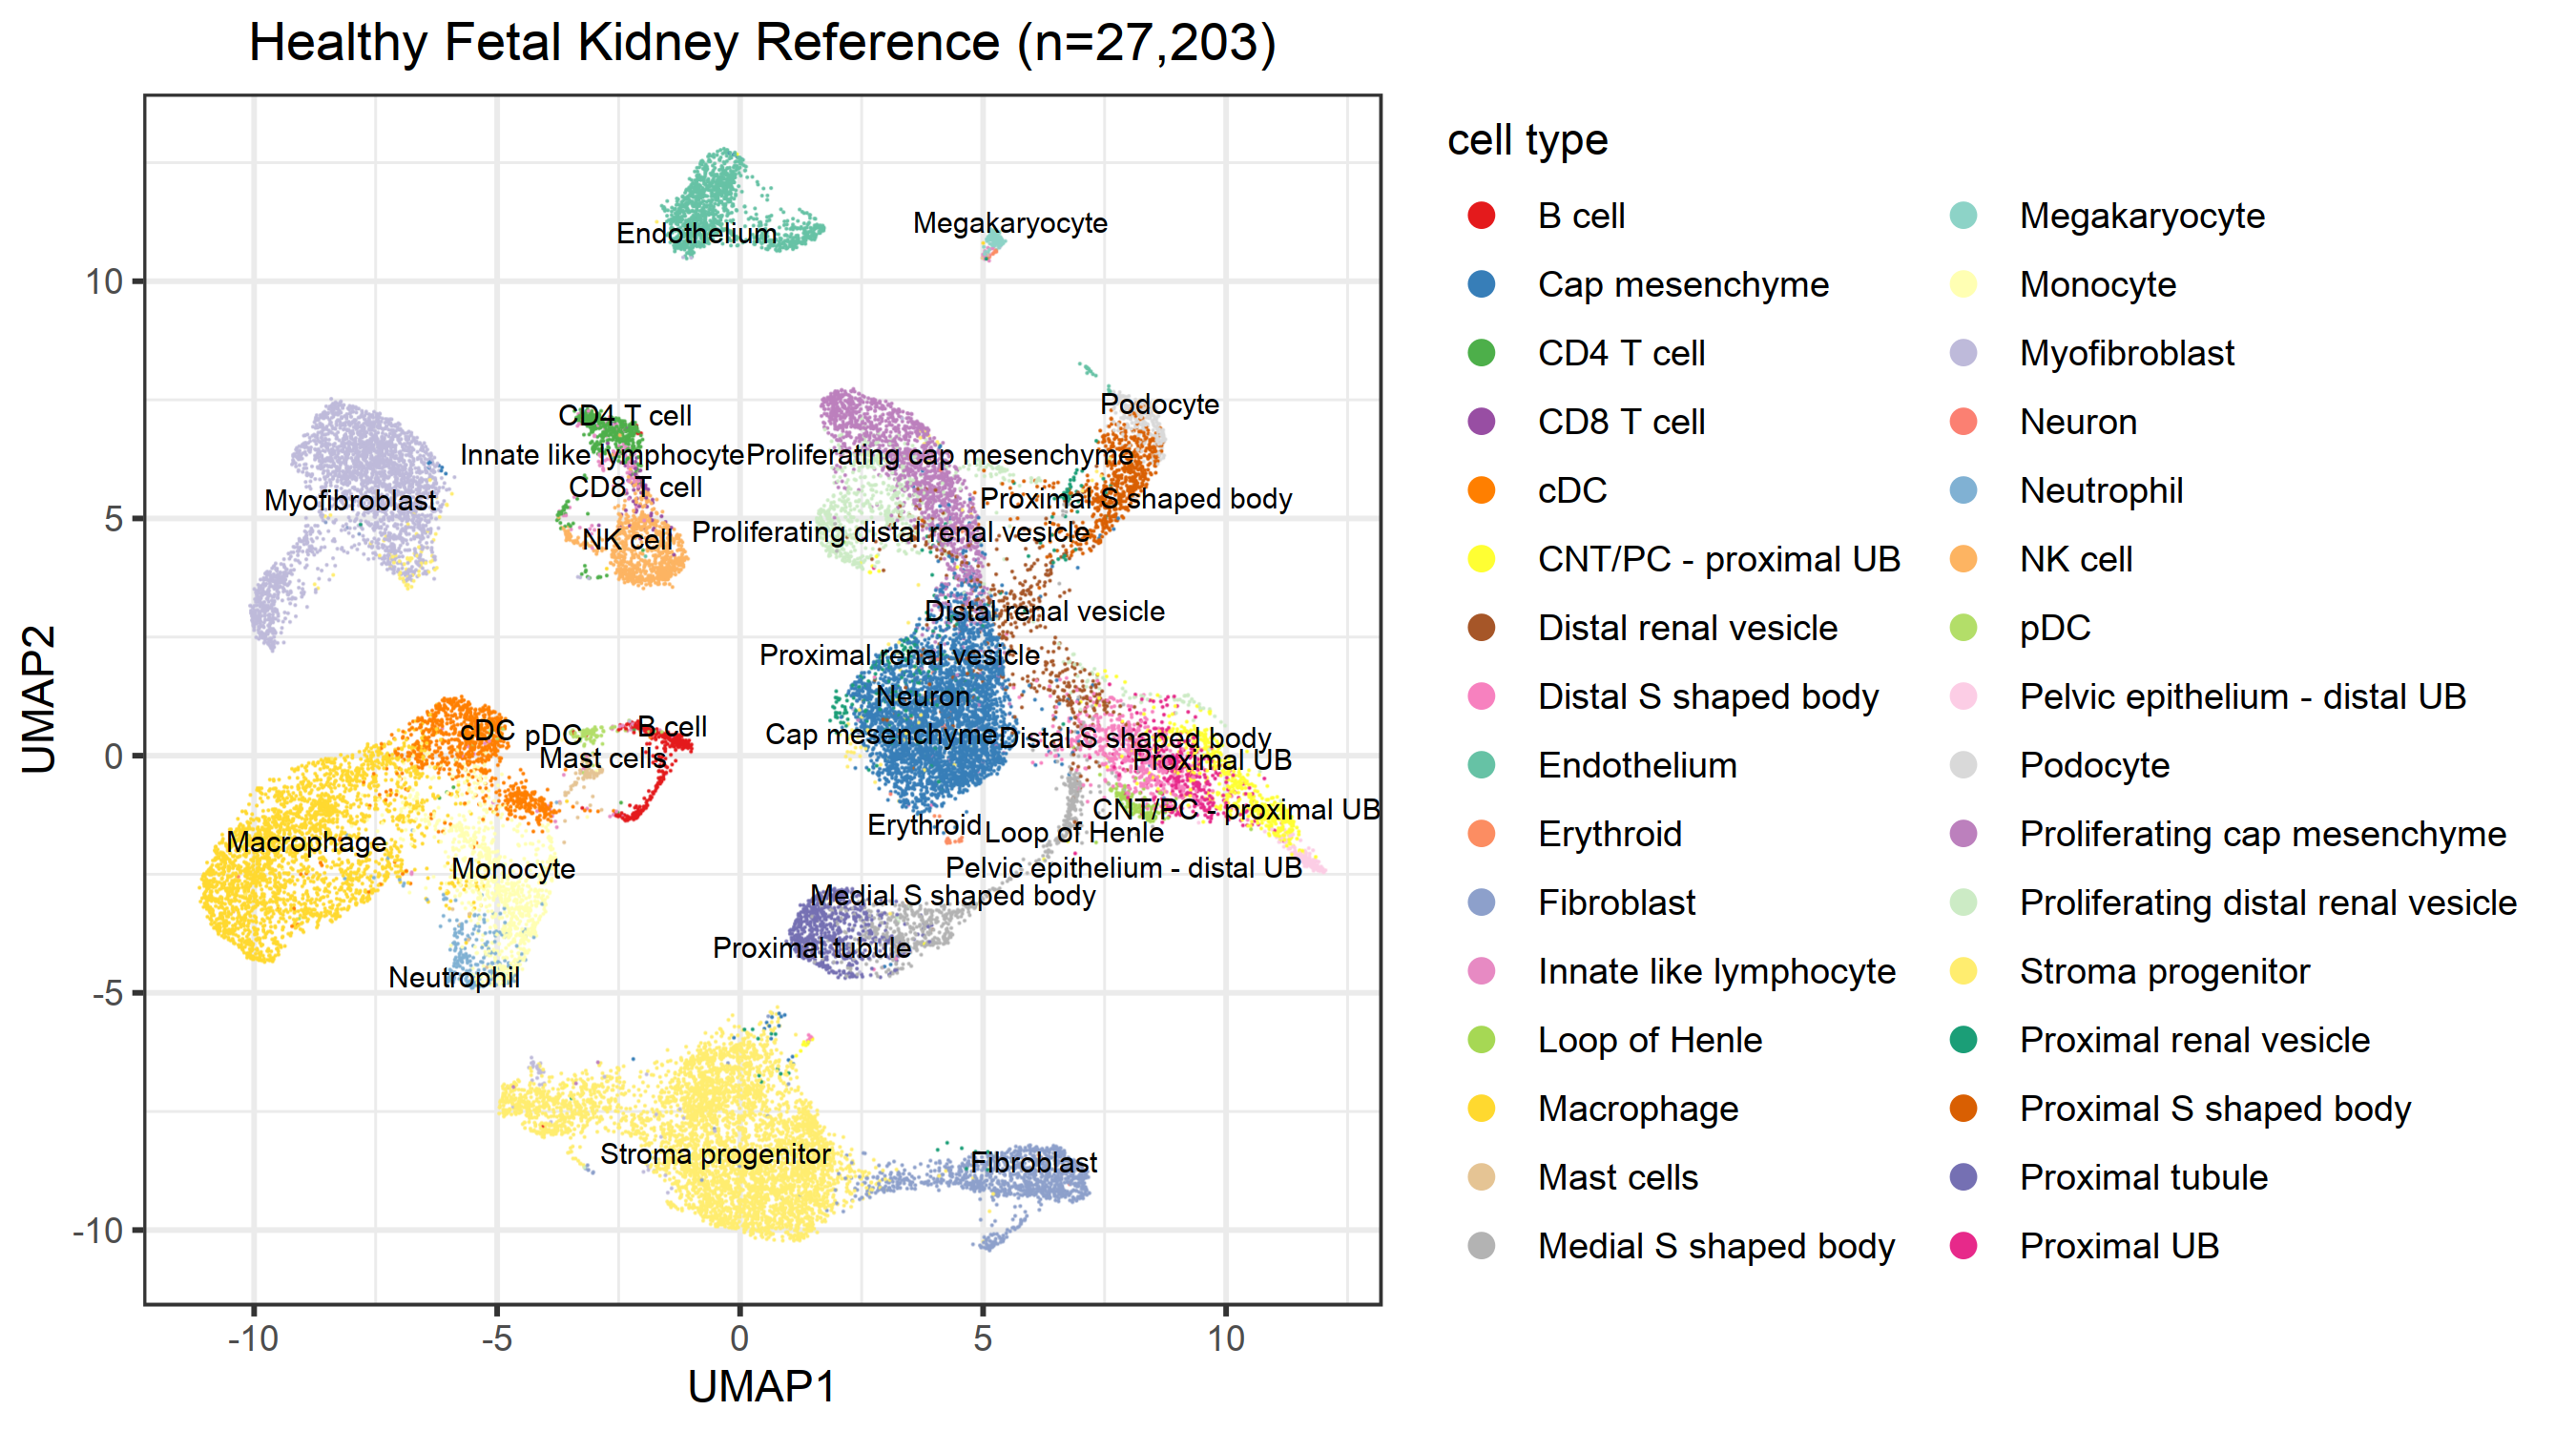

In [15]:
# Plot UMAP visualization
pdf('figures/reference_fetal_kidney_labeled.pdf', height = 5, width = 9, useDingbats = FALSE)
fig.size(5, 9)

# Add cell type labels (at median coordinate per cell type)
labels.cent = umap_labels %>% 
    dplyr::group_by(cell_type) %>% # group_by_at takes variable column name
    dplyr::select(UMAP1, UMAP2) %>% 
    dplyr::summarize_all(median)

p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.2, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Healthy Fetal Kidney Reference (n=27,203)', color = 'cell type') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=9)) + 
    scale_colour_manual(values = mycolors) +
    guides(colour = guide_legend(override.aes = list(size = 3) )) #, ncol = 4))

p = p + ggrepel::geom_text_repel(data = labels.cent, aes(x= UMAP1, y = UMAP2, label = cell_type), 
                    segment.alpha = 0.5, segment.size = 0.2, box.padding = 0.01, color = 'black', size = 2.5)
print(p)
dev.off()
p

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


png 
  2

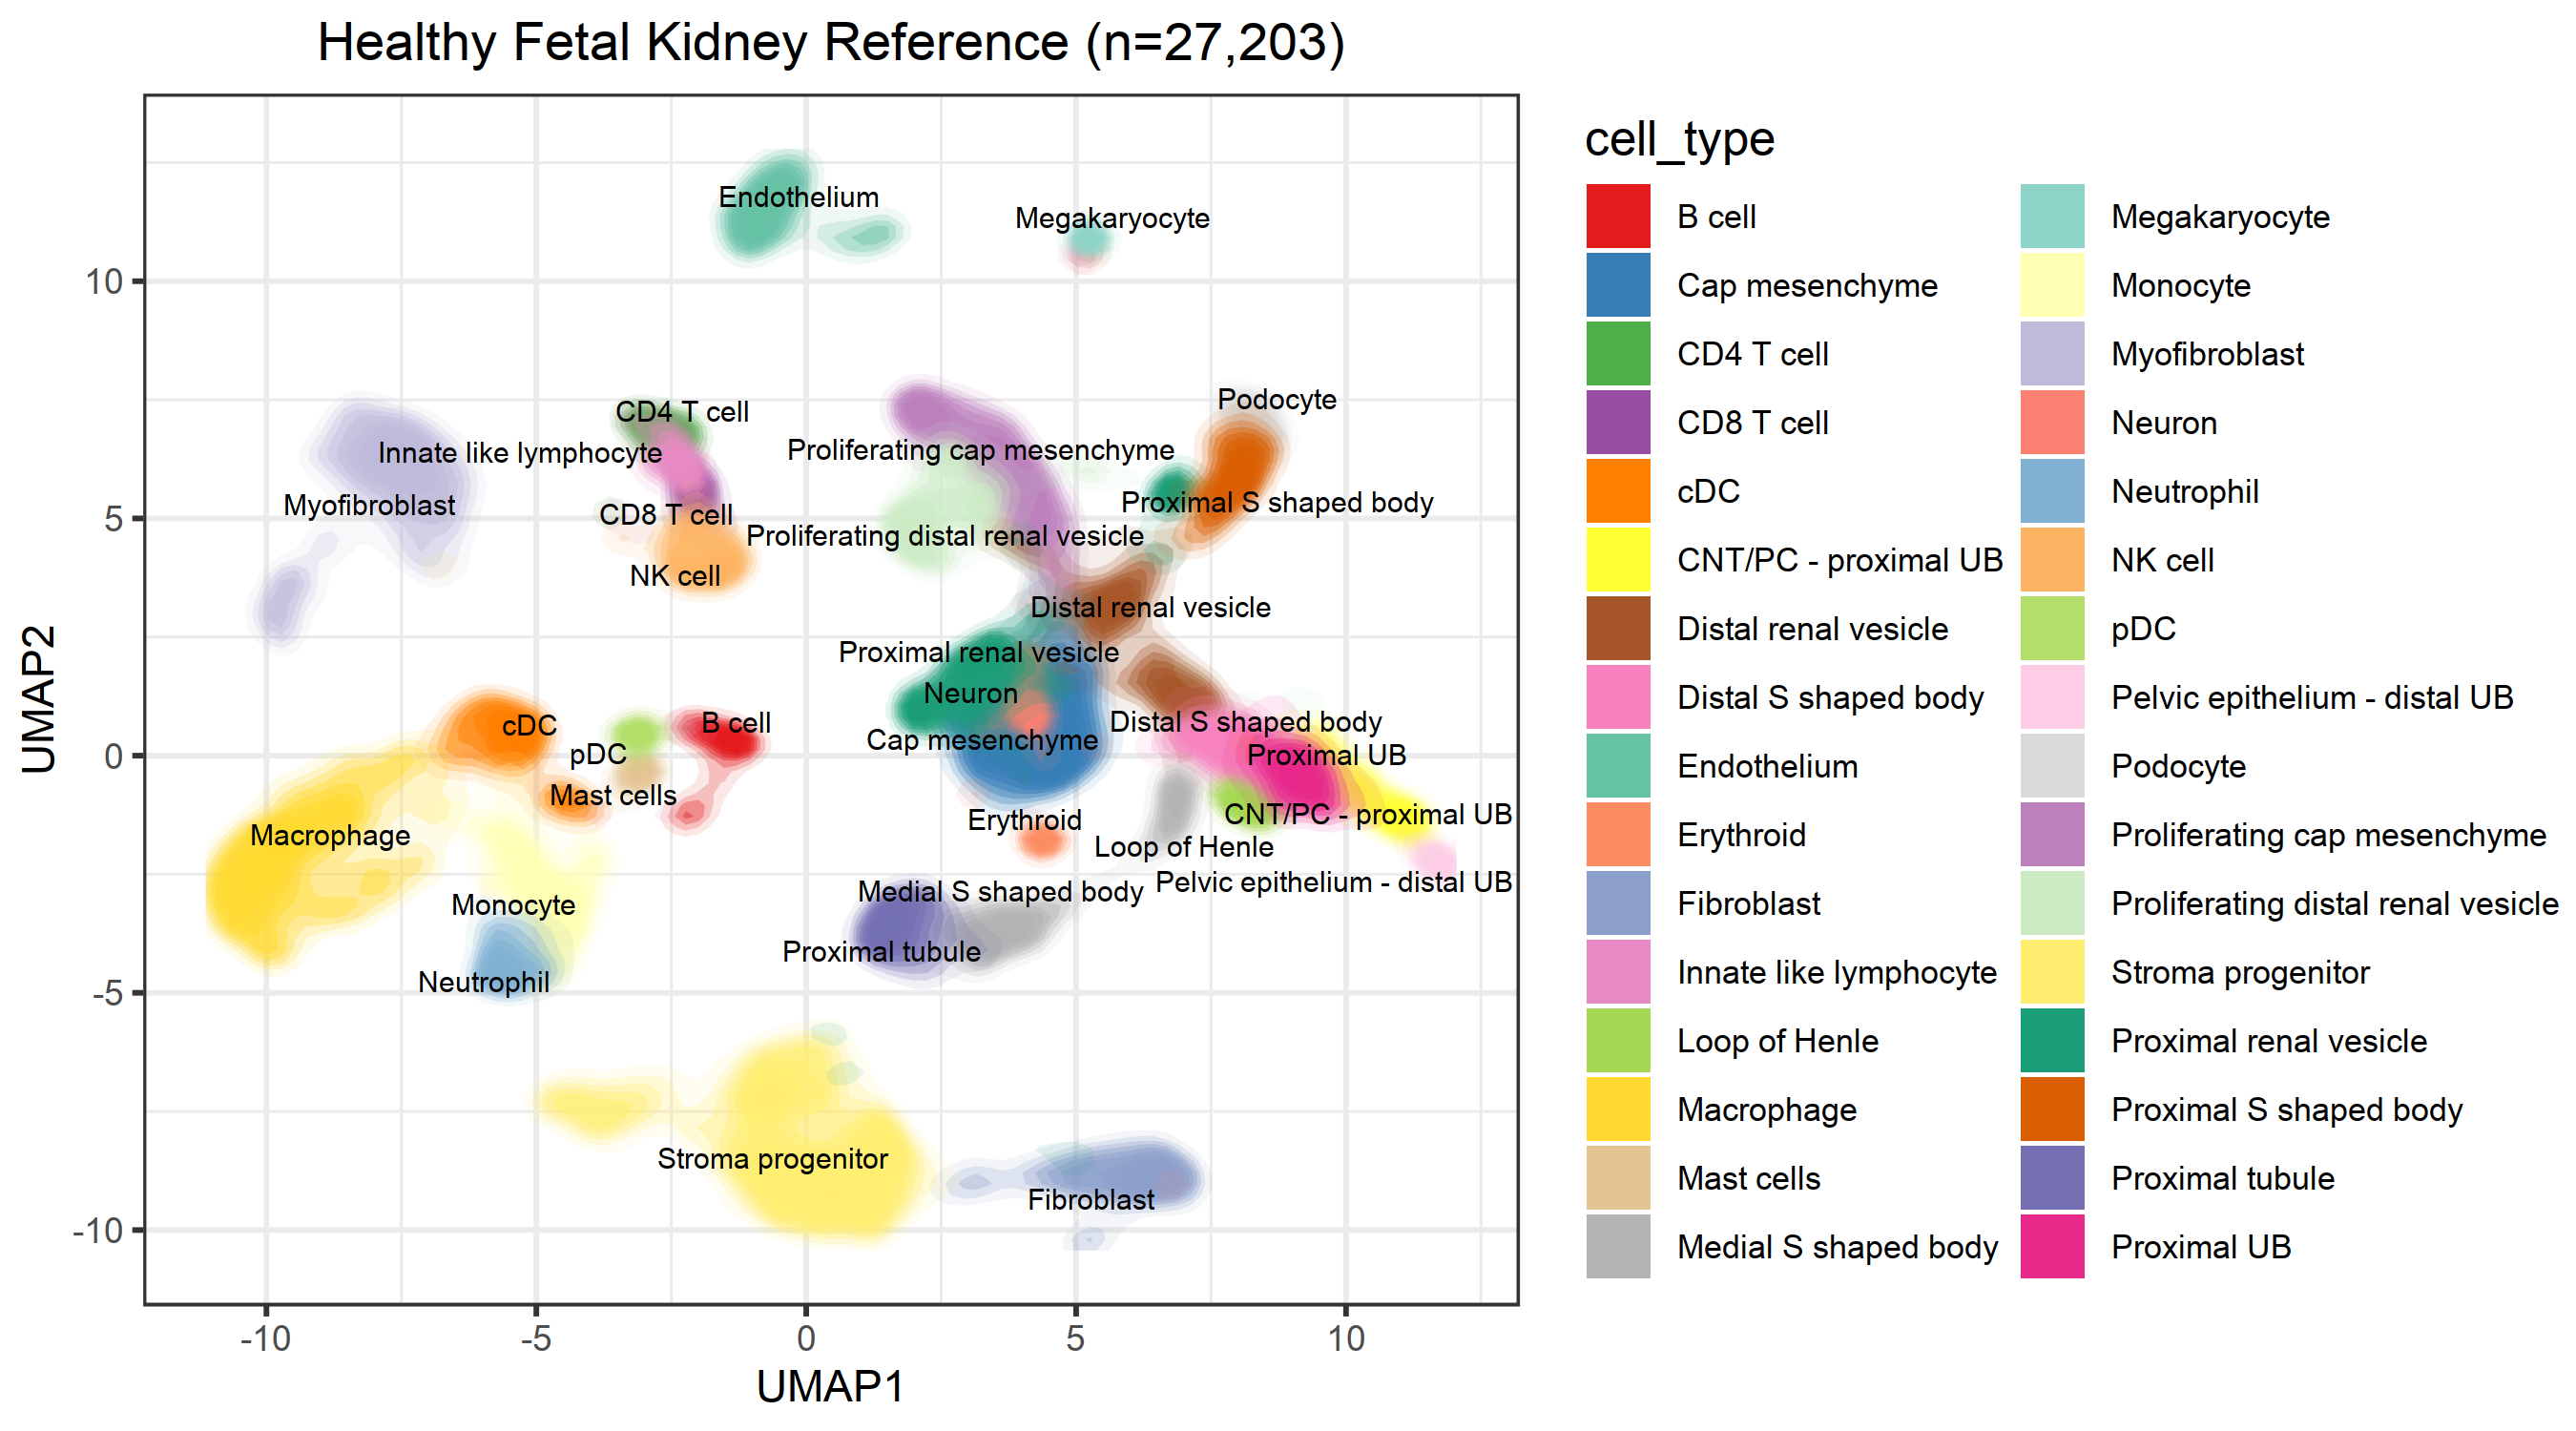

In [16]:
pdf('figures/reference_fetal_kidney_densitywithkey.pdf', height = 5, width = 9, useDingbats = FALSE)
fig.size(5, 9)

p = symphony::plotReference(reference, color.by = 'cell_type', show.labels = FALSE, 
                    title = 'Healthy Fetal Kidney Reference (n=27,203)', as.density = TRUE, 
                    show.centroids = FALSE, celltype.colors = mycolors, bandwidth = 1, bins = 10) + 
                    theme(legend.position = 'right')
p = p + ggrepel::geom_text_repel(data = labels.cent, aes(x= UMAP1, y = UMAP2, label = cell_type), 
                    segment.alpha = 0.5, segment.size = 0.2, box.padding = 0.1, color = 'black', size = 2.5)
print(p)
dev.off()
p

### Map query (RCC tumor)

UMI counting were performed using the 10x Cell Ranger analysis pipeline v3.1. Reads were aligned to the human genome reference b37 with the GENCODE 30 annotation lifted over to GRCh37 (Frankish et al., 2019).

From Bi et al. https://www.sciencedirect.com/science/article/pii/S1535610821001173#bib21

In [17]:
reference = readRDS('../pre-built_references/kidney_healthy_fetal_reference.rds')
query_exp = readRDS('../data/cancer/rcc_query_exp_norm.rds')
query_metadata = readRDS('../data/cancer/rcc_query_metadata.rds')
query = symphony::mapQuery(query_exp, query_metadata, reference, vars = c('donor_id'),
                 do_normalize = FALSE)

Scaling and synchronizing query gene expression

Found 1723 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [18]:
query$meta_data$Lineage = plyr::mapvalues(query$meta_data$Lineage, 
                                           from = c("Normal Tissue"), to = c("Stromal"))

# Sync column names
reference$meta_data$cell_type_refquery = paste0('Ref_', reference$meta_data$cell_type)
query$meta_data$cell_type_refquery = paste0('Query_', query$meta_data$cell_type)
r_metadata = reference$meta_data[, c('Barcode', 'Experiment', 'cell_type_refquery')]
q_metadata = query$meta_data[, c('NAME', 'donor_id', 'cell_type_refquery')]
colnames(r_metadata) = colnames(q_metadata)

r_metadata$ref_query = 'Reference'
q_metadata$ref_query = paste('Query', query$meta_data$Lineage)
meta_data_combined = rbind(q_metadata, r_metadata)

# Add the UMAP coordinates to the metadata
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# To plot query cells on top
umap_combined_labels = umap_combined_labels[order(-as.numeric(factor(umap_combined_labels$ref_query))),]

png 
  2

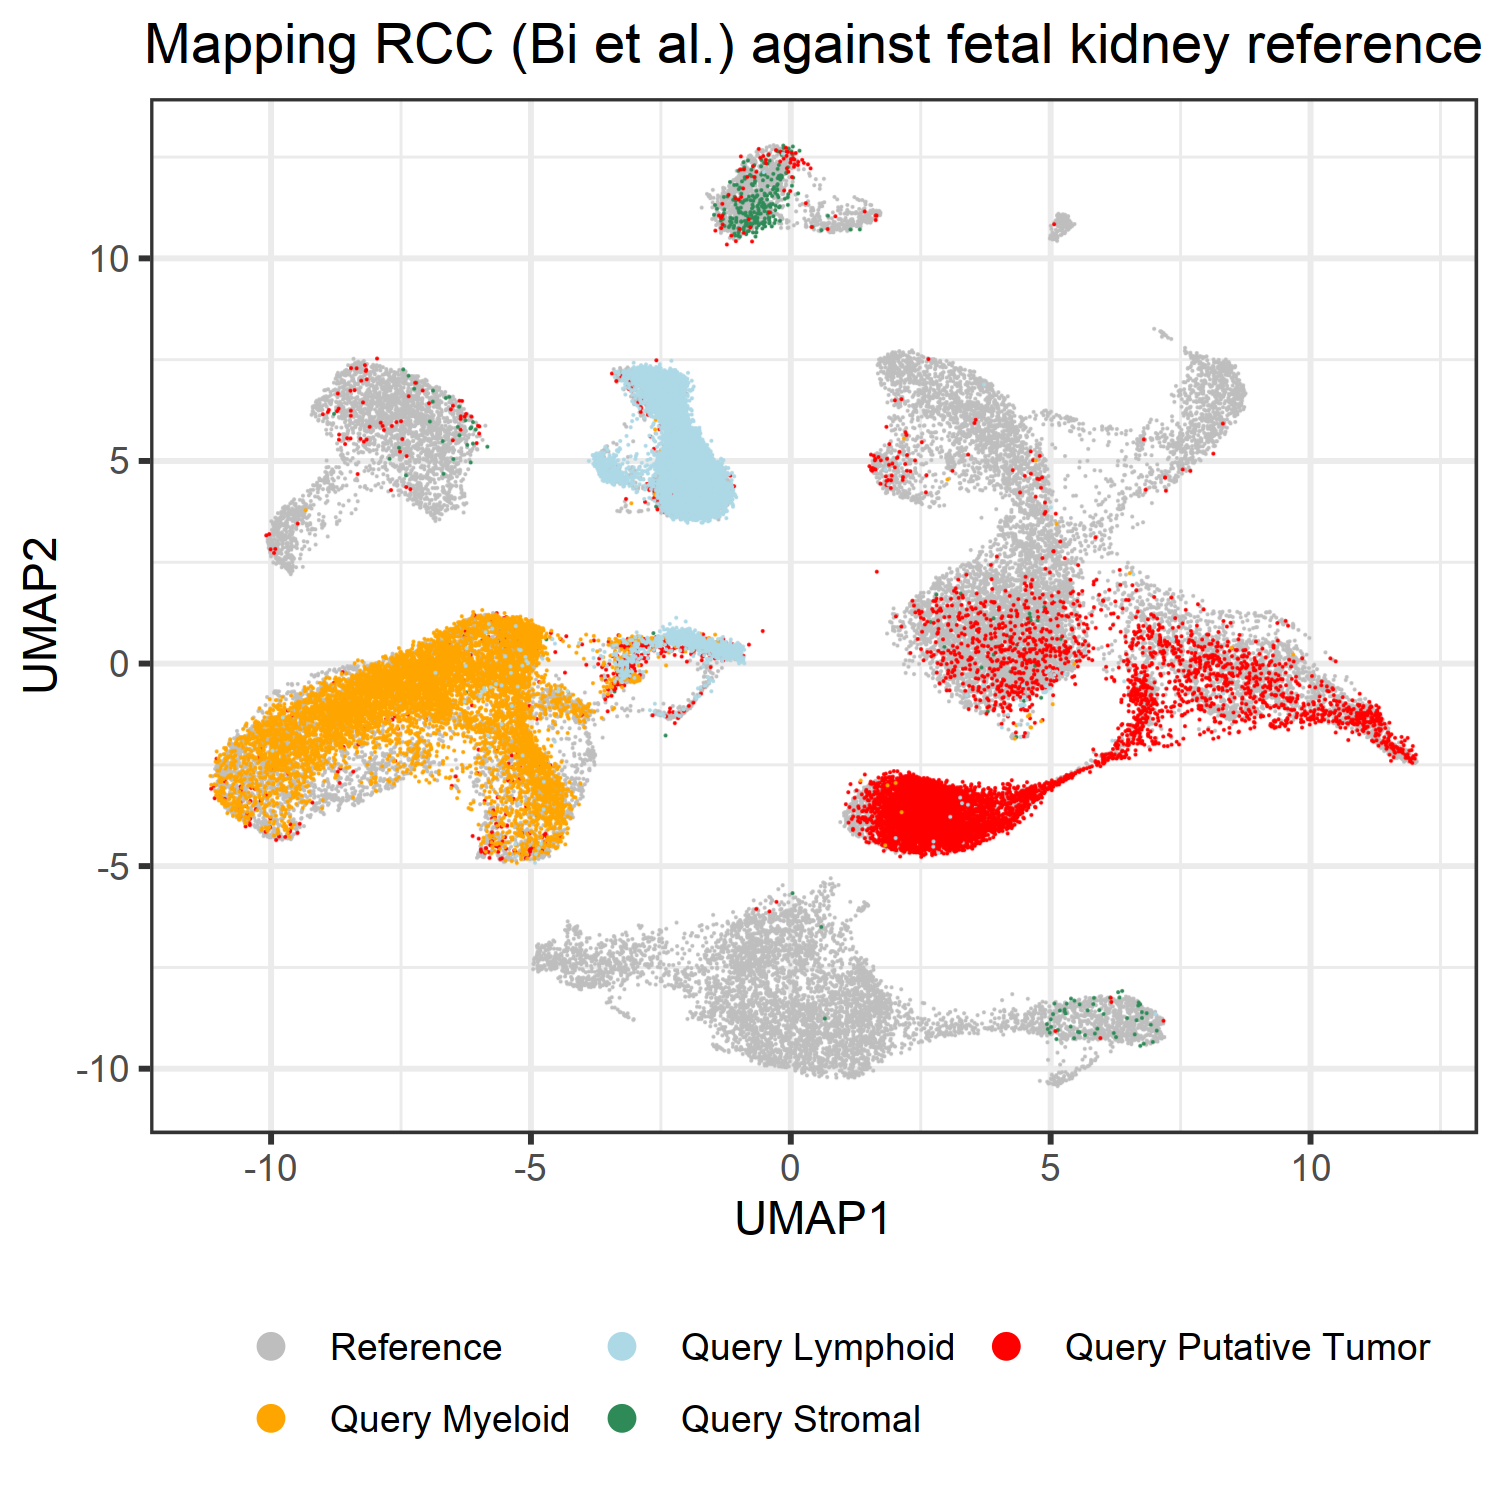

In [19]:
pdf('figures/mapping_rcc_to_healthy_fetal.pdf', height = 5, width = 5, useDingbats = FALSE)
fig.size(5, 5)

q = umap_combined_labels %>%
    ggplot(aes(x = UMAP1, y = UMAP2, col = ref_query)) +
    geom_point_rast(size = 0.2, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Mapping RCC (Bi et al.) against fetal kidney reference', color = '') + 
    theme(plot.title = element_text(hjust = 0.5), legend.position = "bottom") +
    scale_colour_manual(values = c('Reference' = 'gray', 
                                   'Query Myeloid' = 'orange',
                                   'Query Lymphoid' = 'lightblue',
                                   'Query Stromal' = 'seagreen',
                                   'Query Putative Tumor' = 'red')) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 3)) +
    theme(strip.text.x = element_text(size=13))

print(q)
dev.off()
q

Predict query annotations using k-NN

In [20]:
set.seed(0)
query = symphony::knnPredict(query_obj = query, ref_obj = reference, 
                   train_labels = reference$meta_data$cell_type,
                   k = 20, save_as = 'cell_type_10_nn', confidence = TRUE)
saveRDS(query, 'figures/query.rds')

### Plot tumor predictions

In [36]:
query = readRDS('figures/query.rds')

Plot by TP1, TP2, Cycling tumor

In [37]:
## Extract tumor cell results
query_tumor = query$meta_data[which(query$meta_data$cell_type %in% c('TP1', 'TP2', 'Cycling Tumor')),]

## Cell type mappings heatmap for tumor only
query_tumor$cell_type = droplevels(as.factor(query_tumor$cell_type))
res_tumor = symphony:::evaluate(query_tumor$cell_type, query_tumor$cell_type_10_nn)
Conf_tumor = res_tumor$Conf / rowSums(res_tumor$Conf)

In [38]:
Conf_tumor = Conf_tumor[ c('TP1', 'TP2', 'Cycling Tumor'), ]

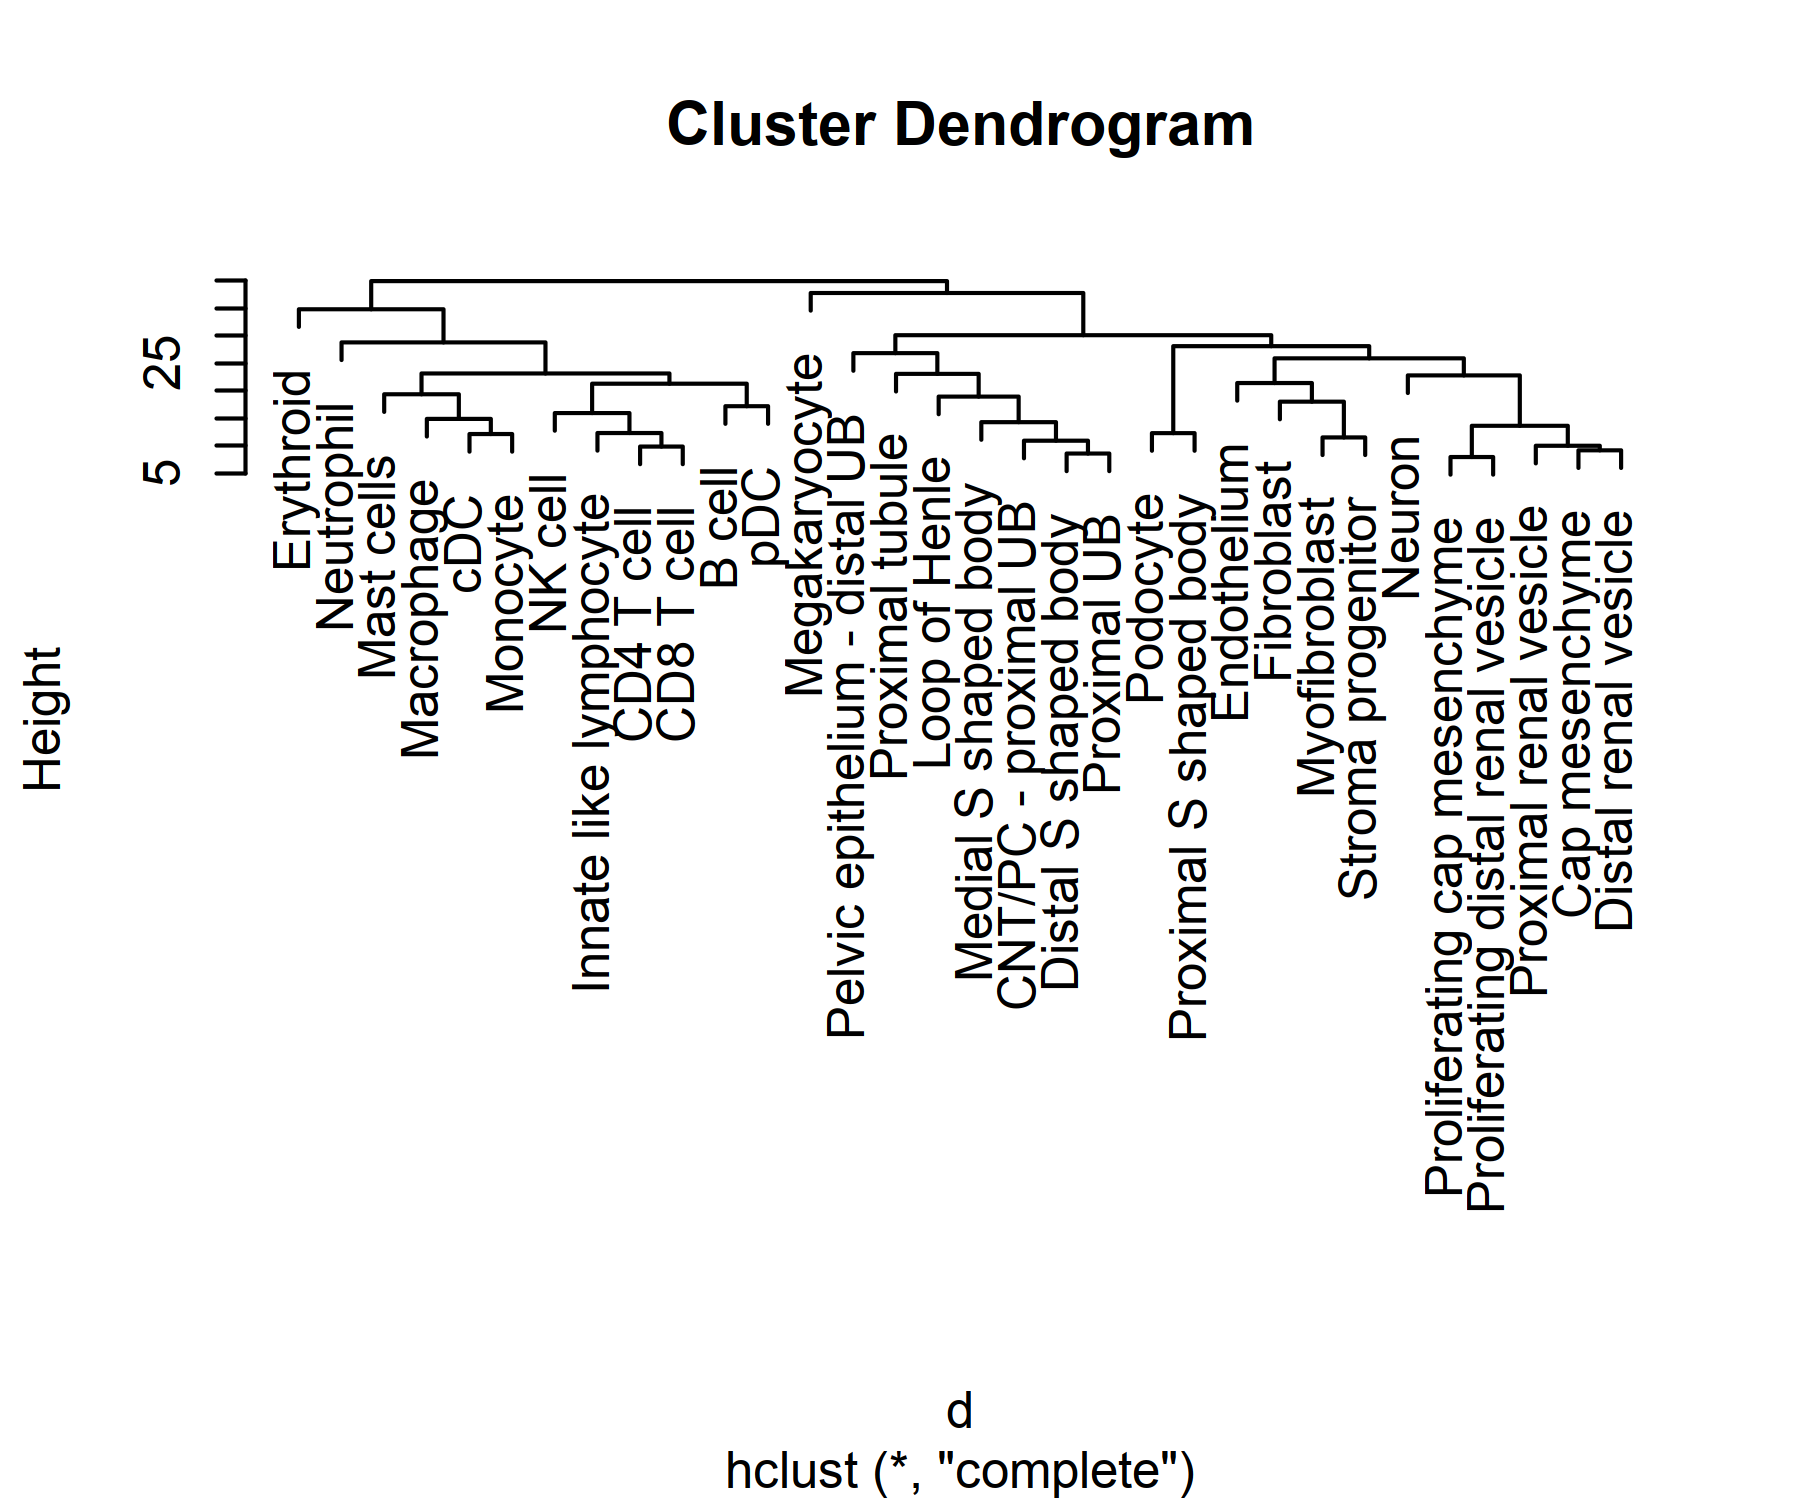

In [39]:
## Order the cols (predicted labels) based on gene expression similarity of the reference types
## as a way to cluster them in an unbiased way
# Calculate the average expression per cell type
avg_exprs = NULL
for (cell_type in unique(colnames(Conf_tumor))) {
    indices = which(reference$meta_data$cell_type == cell_type)
    exprs_type = exp_norm[, indices]
    exprs_mean = rowMeans(exprs_type)
    avg_exprs = cbind(avg_exprs, exprs_mean)
}
colnames(avg_exprs) = unique(colnames(Conf_tumor))

fig.size(5, 6)
d = dist(as.matrix(t(avg_exprs)))   # find distance matrix 
hc1 = hclust(d)                      # apply hirarchical clustering 
plot(hc1)

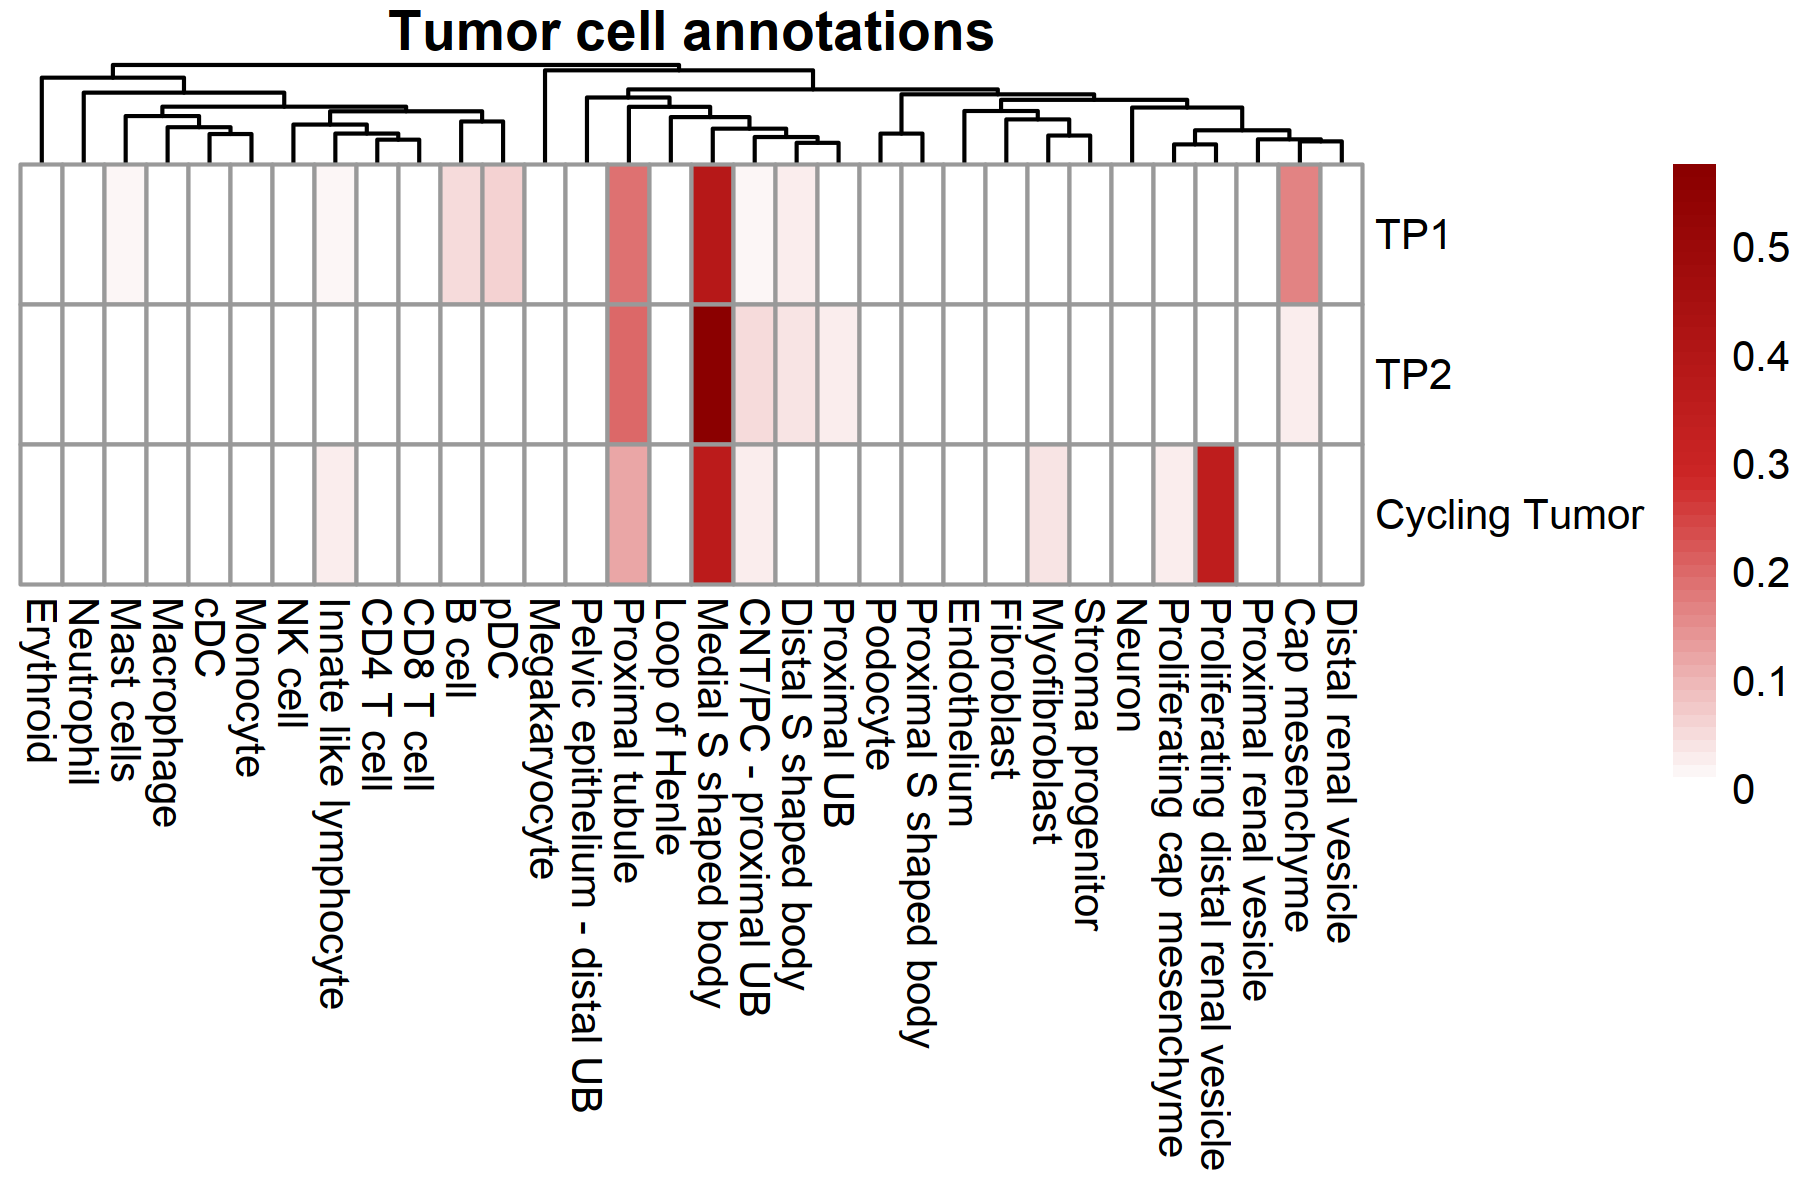

In [40]:
fig.size(4, 6)
pheatmap(Conf_tumor, main = 'Tumor cell annotations', 
        treeheight_col = 20, treeheight_row = 20, cluster_rows = F, cluster_cols = hc1,
        color=colorRampPalette(c("white", "firebrick3", "darkred"))(50))

# Save to file
pheatmap(Conf_tumor, main = 'Tumor cell annotations', 
        filename = 'figures/pheatmap_tumor.pdf', height = 4, width = 6,
        treeheight_col = 20, treeheight_row = 20, cluster_rows = F, cluster_cols = hc1,
        color=colorRampPalette(c("white", "firebrick3", "darkred"))(50))

### Plot immune and stromal compartment predictions

Plot by Bi et al. cell type

In [41]:
## Extract immune and stromal cells
query_immune = query$meta_data[which(query$meta_data$cell_type %in% 
                            c('CD8+ T cell', 'T-Helper', 'T-Reg', 'TAM', 'Plasma cell', 'Fibroblast',
                'NK', 'NKT', 'Endothelial', 'MitoHigh Myeloid', 'Monocyte', 'B cell', 'DC', 'Mast cell')),]

## Cell type mappings heatmap
query_immune$cell_type = droplevels(as.factor(query_immune$cell_type))
res_immune = symphony:::evaluate(query_immune$cell_type, query_immune$cell_type_10_nn)
Conf_immune = res_immune$Conf / rowSums(res_immune$Conf)

In [42]:
Conf_immune = Conf_immune[c('Mast cell', 'TAM', 'MitoHigh Myeloid', 'DC', 'Monocyte',
                            'NKT', 'NK', 'CD8+ T cell', 'T-Helper', 'T-Reg',
                            'B cell', 'Plasma cell',
                            'Endothelial', 'Fibroblast'), ]

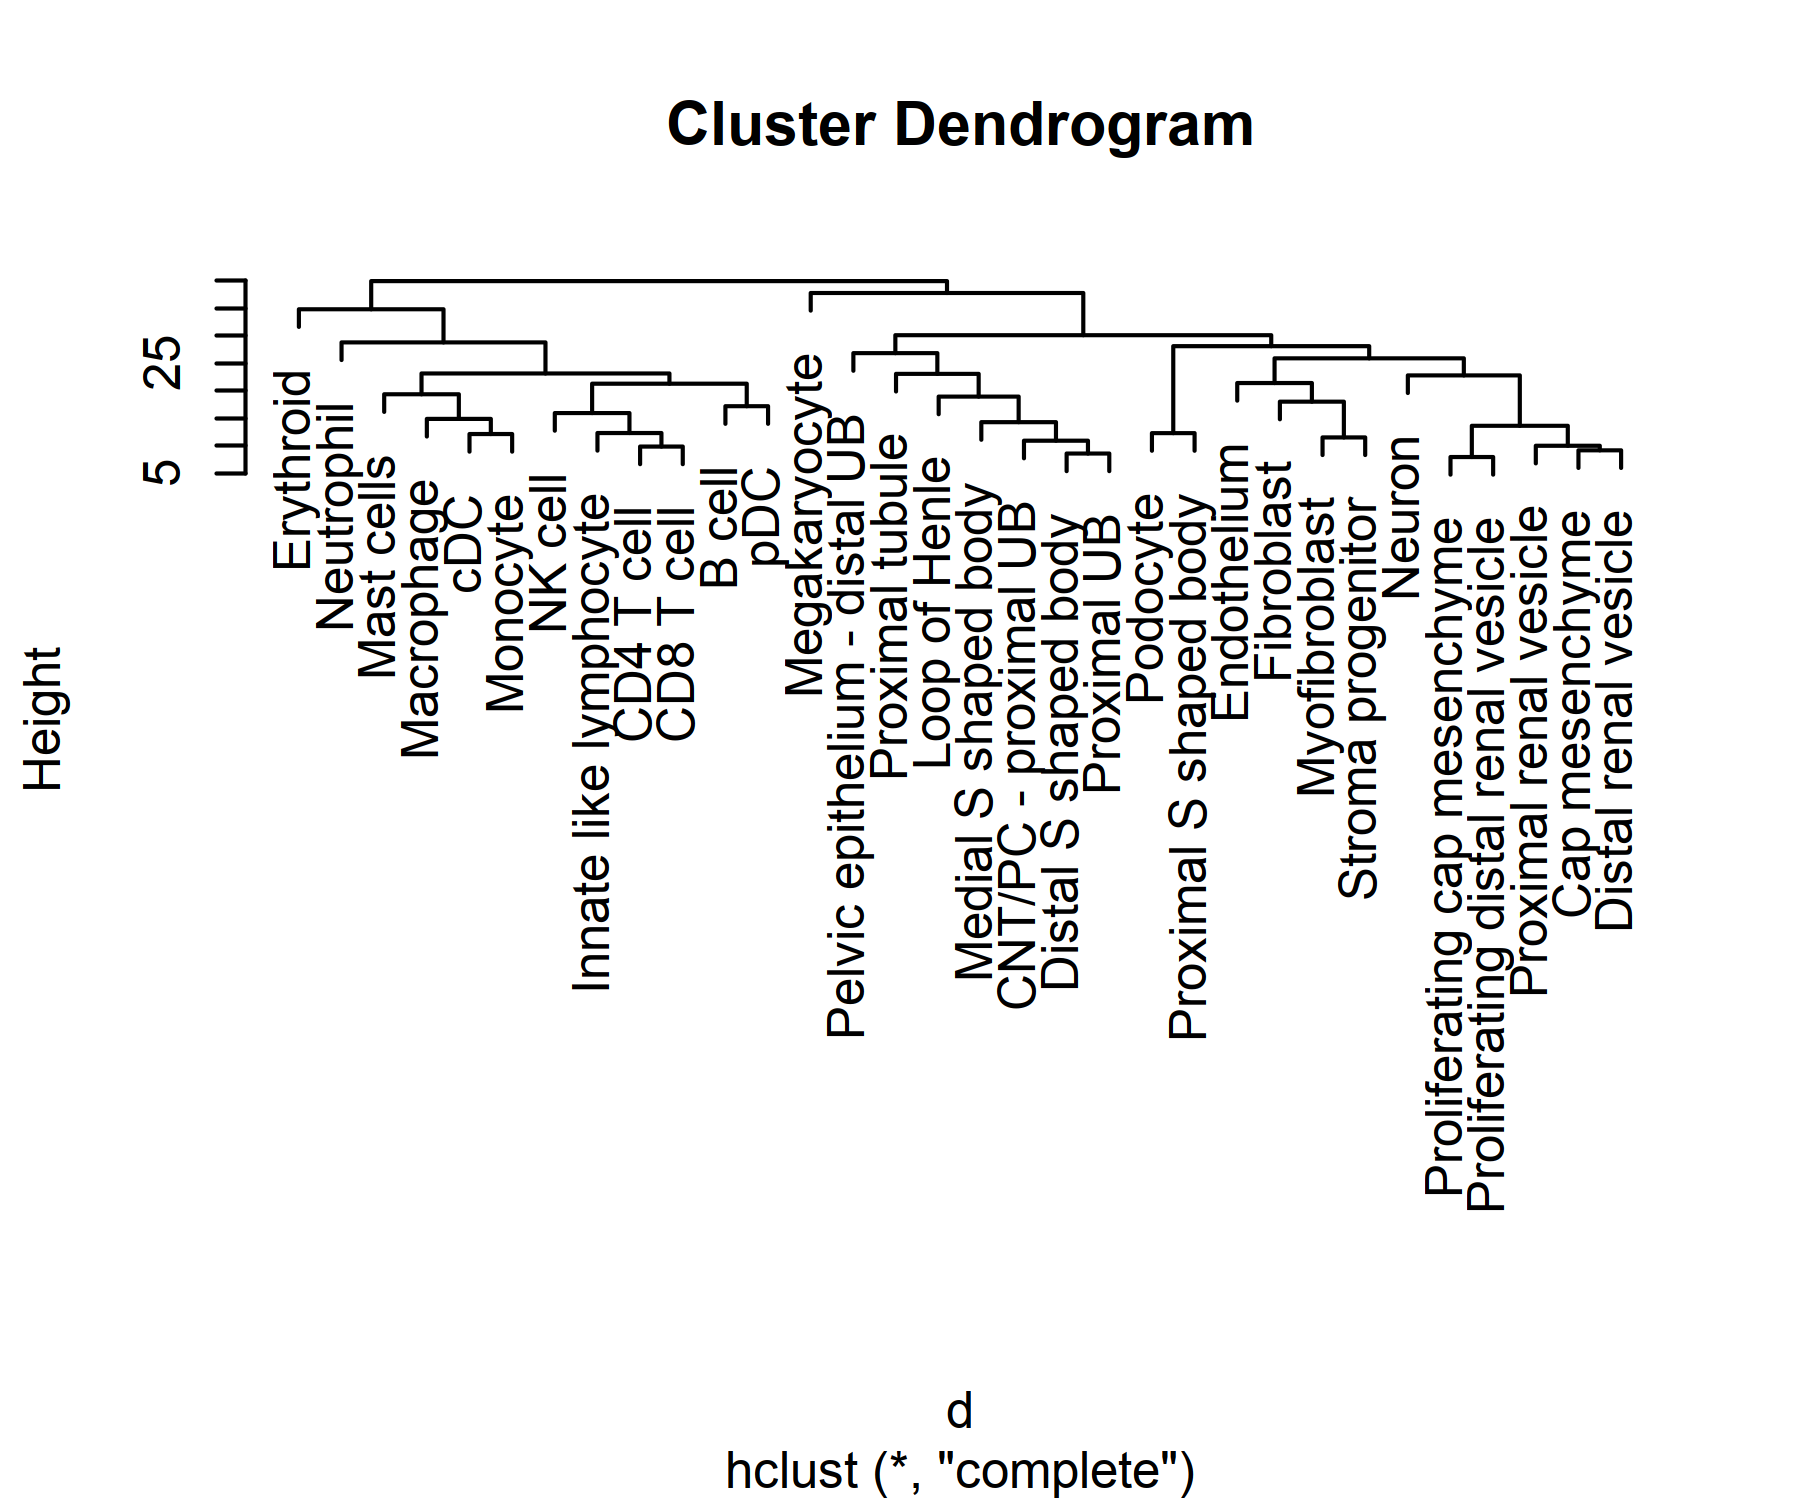

In [43]:
## Order the cols (predicted labels) based on gene expression similarity of the reference types
## as a way to cluster them in an unbiased way
# Calculate the average expression per cell type
avg_exprs = NULL
for (cell_type in unique(colnames(Conf_immune))) {
    indices = which(reference$meta_data$cell_type == cell_type)
    exprs_type = exp_norm[, indices]
    exprs_mean = rowMeans(exprs_type)
    avg_exprs = cbind(avg_exprs, exprs_mean)
}
colnames(avg_exprs) = unique(colnames(Conf_immune))

fig.size(5, 6)
d = dist(as.matrix(t(avg_exprs)))   # find distance matrix 
hc2 = hclust(d)                      # apply hirarchical clustering 
plot(hc2)

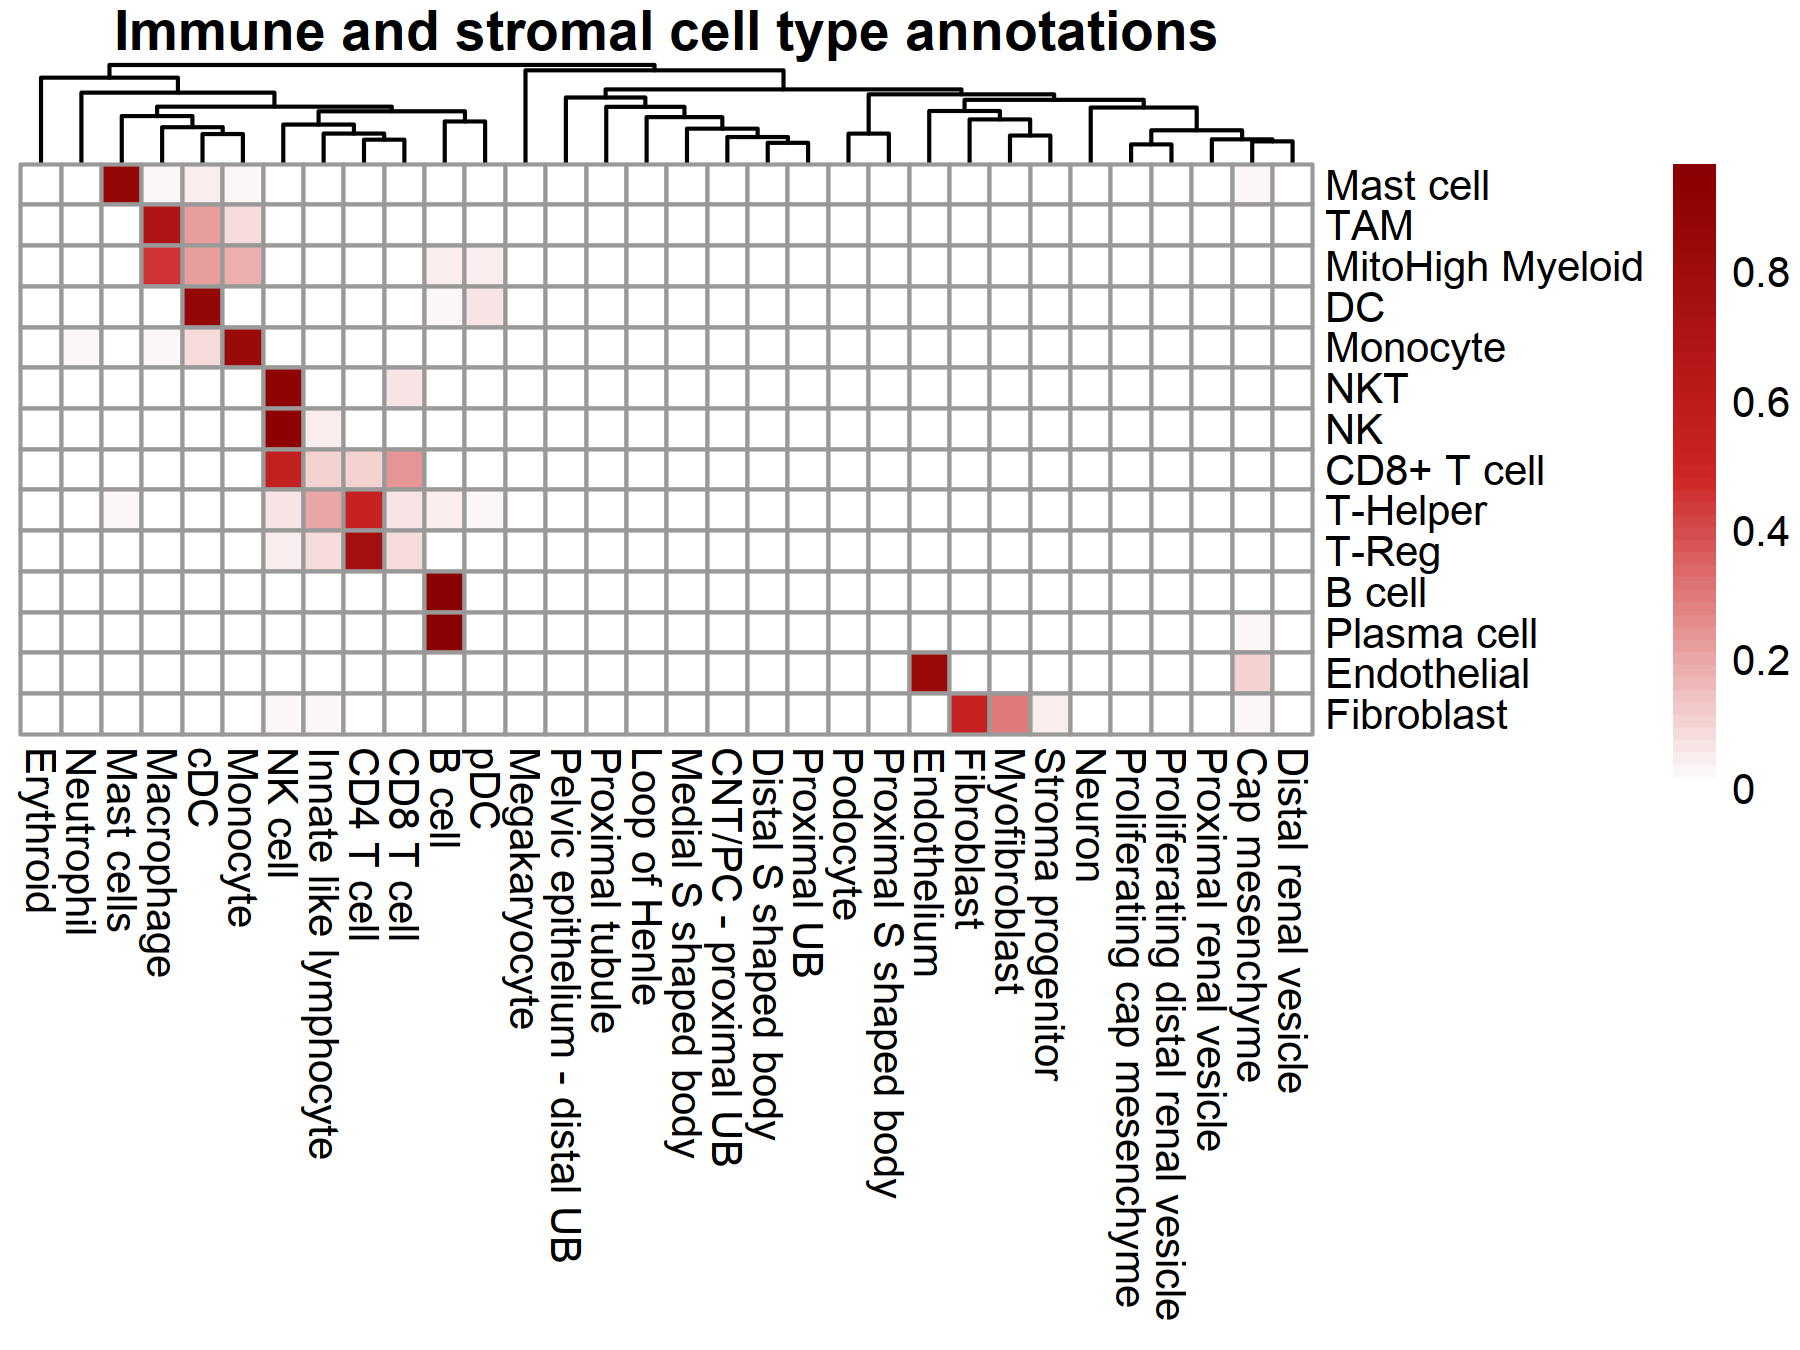

In [44]:
fig.size(4.5, 6)
# save to file
pheatmap(Conf_immune, main = 'Immune and stromal cell type annotations', 
        treeheight_col = 20, treeheight_row = 20, cluster_rows = F, cluster_cols = hc2,
        color=colorRampPalette(c("white", "firebrick3", "darkred"))(50))

# save to file
pheatmap(Conf_immune, main = 'Immune and stromal cell type annotations', 
             filename = 'figures/pheatmap_immune_stromal.pdf', width = 6, height = 4.5,
        treeheight_col = 20, treeheight_row = 20, cluster_rows = F, cluster_cols = hc2,
        color=colorRampPalette(c("white", "firebrick3", "darkred"))(50))

png 
  2

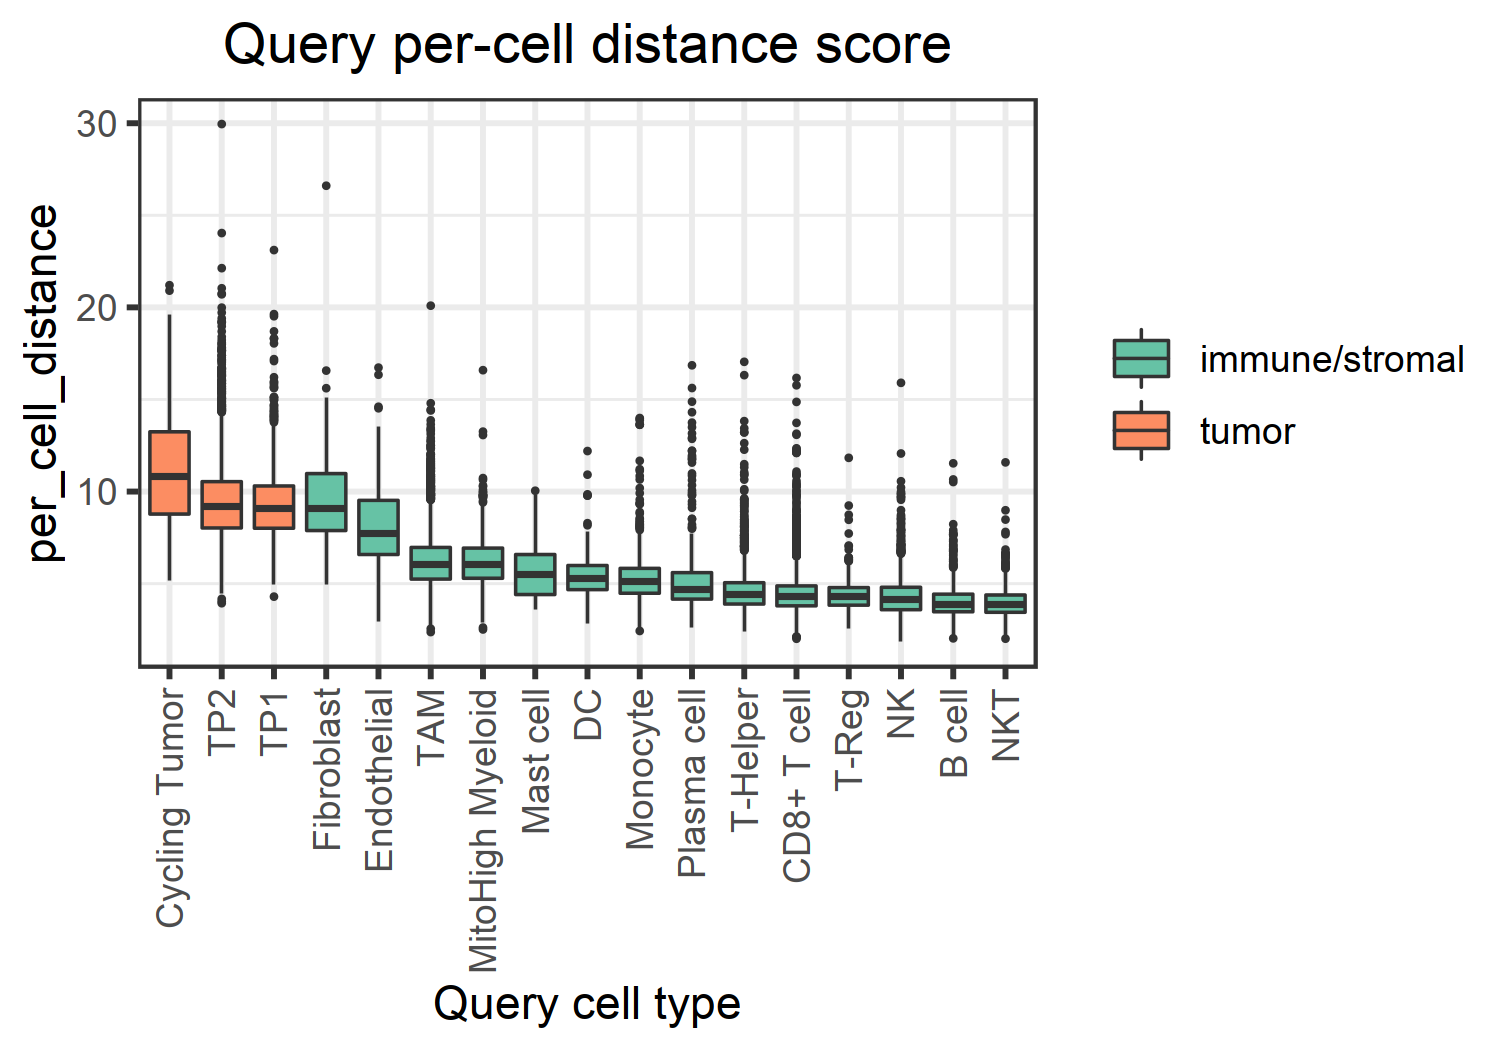

In [48]:
## Calc per-cell score
query$meta_data$per_cell_distance = calcPerCellConfidence(reference, query)

# Plot per-cell score

query$meta_data$isTumor = 'immune/stromal'
query$meta_data$isTumor[which(query$meta_data$cell_type %in% 
                              c('TP1', 'TP2', 'Cycling Tumor'))] = 'tumor'
meta_data = query$meta_data[-which(query$meta_data$cell_type == 'Misc/Undetermined'),]

pdf('figures/per_cell_distance.pdf', height = 3.5, width = 5, useDingbats = FALSE)
fig.size(3.5, 5)
p = ggplot(meta_data) +
        theme_bw() + 
        geom_boxplot(aes(x = reorder(cell_type, -per_cell_distance, median), 
                         y = per_cell_distance, fill = isTumor), outlier.size = 0.1, size = 0.3) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
        scale_fill_brewer(palette = 'Set2') + theme(legend.title = element_blank()) +
        ggtitle('Query per-cell distance score') + theme(plot.title = element_text(hjust = 0.5)) +
        xlab('Query cell type')
print(p)
dev.off()
p

In [46]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggrastr_0.2.3        pheatmap_1.0.12      RColorBrewer_1.1-2  
 [4] forcats_0.5.1        stringr_1.4.0        dplyr_1.0.6         
 [7] readr_1.4.0          tidyr_1.1.3          tibble_3.1.2        
[10] ggplot2_3.3.4        tidyverse_1.